In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import math
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm
from itertools import combinations
# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets
from nilearn import plotting
# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.metrics import ave_control, modal_control
from nctpy.utils import (
matrix_normalization,
normalize_state,
normalize_weights,
)
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines, set_plotting_params, reg_plot
import networkx as nx

In [2]:
A = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/A.txt')
G = nx.from_numpy_matrix(A)
print(f"The graph is {'connected' if nx.is_connected(G) else 'not connected'}.")

The graph is connected.


In [3]:
def compute_opt_control_set(A, x0, xf, c, rho, S, system=None, T=1, control_size=1, numerical_threshold=1e-8):
    
    results = []
    n_nodes = A.shape[0]
    all_combinations = combinations(range(n_nodes), control_size)
    num_combinations = math.comb(n_nodes, control_size)
    A_norm = matrix_normalization(A, system, c=gamma)
    valid_combination_found = False
    np.random.seed(0)
    

    for comb in tqdm(all_combinations, desc=f"Control size {control_size}", total=num_combinations):
        B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
        for i in comb:
            B[i, i] = 1

        _, control_signals, numerical_error = get_control_inputs(
            A_norm=A_norm,
            T=T,
            B=B,
            x0=x0,
            xf=xf,
            system=system,
            rho=rho,
            S=S
            
        )


        # Check numerical errors
        if numerical_error[0] <= numerical_threshold and numerical_error[1] <= numerical_threshold:
            valid_combination_found = True
            E = integrate_u(control_signals)
            energy = np.sum(E)
            results.append({'combination': comb, 'energy': energy, 'error': numerical_error})
            
            
    if not valid_combination_found:
        raise ValueError(f"No valid combination found for control size {control_size} with the given numerical threshold.")

    # Sort data by 'energy' in ascending order
    results = sorted(results, key=lambda x: x['energy'])
    
    return results

In [3]:
# balance between minimizing energy or minimizing distance from target state
rho = .2
# time to go from initial to target state
T = .7
# the number of time points the code spits out: T * 1000 + 1
nTime = 701
gamma = 4
# to try and simulate stimuluation, we're gonna weight the B matrix
B_mu = .0005
B_sigma = .00005
system = 'continuous'
S = np.eye(A.shape[0])

# initial to resting

Control size 1: 100%|█████████████████████████| 246/246 [00:42<00:00,  5.80it/s]


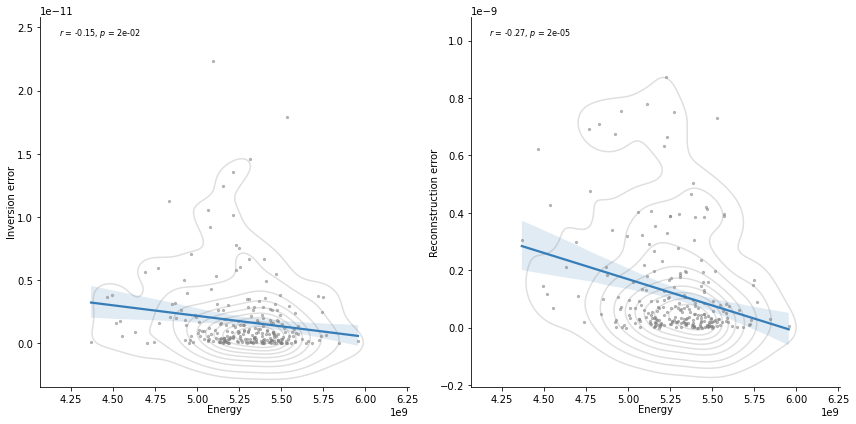

In [5]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/resting_state.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

# results = [{'combination': comb, 'energy': energy, 'error': [error1, error2]}, ...]
results = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
)
energies = np.array([result['energy'] for result in results])
errors1 = np.array([result['error'][0] for result in results])
errors2 = np.array([result['error'][1] for result in results])


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

reg_plot(x=energies, y=errors1, xlabel='Energy', ylabel='Inversion error', annotate='pearson', ax=axs[0])
reg_plot(x=energies, y=errors2, xlabel='Energy', ylabel='Reconnstruction error', annotate='pearson', ax=axs[1])

plt.tight_layout()
plt.show()

In [6]:
for result in results:
    print(f"Stimulation Point: {result['combination']}, Error: {result['error']}")

Stimulation Point: (174,), Error: [1.351592187253517e-13, 3.065540159288508e-10]
Stimulation Point: (175,), Error: [3.67235512142329e-12, 6.227239781597233e-10]
Stimulation Point: (179,), Error: [3.795835436160656e-12, 1.4640711122438066e-10]
Stimulation Point: (153,), Error: [1.6517133861680881e-12, 1.1578917731200553e-10]
Stimulation Point: (147,), Error: [1.7694776138634565e-12, 4.272877976985342e-10]
Stimulation Point: (180,), Error: [5.935424538953261e-13, 6.971602449209985e-11]
Stimulation Point: (176,), Error: [9.291777002419354e-13, 2.1122713808608432e-10]
Stimulation Point: (182,), Error: [5.672459992344469e-12, 2.9886904158026604e-10]
Stimulation Point: (170,), Error: [5.61177837442947e-14, 1.0944477752294618e-10]
Stimulation Point: (40,), Error: [1.3459035971554104e-13, 1.82287804211888e-11]
Stimulation Point: (177,), Error: [6.001622991826723e-12, 6.923715431611069e-10]
Stimulation Point: (183,), Error: [1.6367975023762502e-12, 4.749564509798549e-10]
Stimulation Point: (181

In [9]:
# results = [{'combination': comb, 'energy': energy, 'error': [error1, error2]}, ...]
results_1 = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1
)


with open('/Users/shenxiaoyu/Desktop/NCT/results_1_normlised.txt', 'w') as file:
    for result in results_1:
        output_line = f"Stimulation Point: {result['combination']}, Energy: {result['energy']}, Error: {result['error']}\n"
        file.write(output_line)

Control size 1: 100%|█████████████████████████| 246/246 [00:45<00:00,  5.40it/s]


In [19]:
def compute_opt_control_set_2(A, x0, xf, rho, S, system=None, c=1, T=1, control_size=1, numerical_threshold=1e-8):
    """
    Args:
        A_norm (NxN, numpy array): normalized structural connectivity matrix.
        x0 (Nx1, numpy array): initial state.
        xf (Nx1, numpy array): target state.
        rho (float): mixing parameter.
        S (NxN, numpy array): constraint matrix for state trajectory.
        system (str): system type ('continuous' or 'discrete').
        c (float): scaling factor for A matrix.
        T (float): time horizon.
        control_size (int): size of the control set.
        numerical_threshold (float): threshold for numerical errors.
    
    Returns:
        results (list): A list of dictionaries with 'combination', 'energy', and 'error' for each valid control set.
    """
    results = []
    n_nodes = A.shape[0]
    all_combinations = combinations(range(n_nodes), control_size)
    num_combinations = math.comb(n_nodes, control_size)
    A_norm = matrix_normalization(A, system, c=gamma)
    valid_combination_found = False
    np.random.seed(0)
    

    for comb in tqdm(all_combinations, desc=f"Control size {control_size}", total=num_combinations):
        B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
        for i in comb:
            B[i, i] = 1
            
            
        _, control_signals, numerical_error = get_control_inputs(
            A_norm=A_norm,
            T=T,
            B=B,
            x0=x0,
            xf=xf,
            system=system,
            rho=rho,
            S=S
            
        )
        
     
        # Check numerical errors
        if numerical_error[0] <= numerical_threshold and numerical_error[1] <= numerical_threshold:
            valid_combination_found = True

            B_diag = np.diag(B)
            B_diag_expanded = B_diag[:, np.newaxis]  
            u_norm = np.linalg.norm(control_signals.T * B_diag_expanded, axis=0)
            energy = np.sum(u_norm) / control_signals.shape[0]
            results.append({'combination': comb, 'energy': energy, 'error': numerical_error})
            
            
    if not valid_combination_found:
        raise ValueError(f"No valid combination found for control size {control_size} with the given numerical threshold.")

    # Sort data by 'energy' in ascending order
    results = sorted(results, key=lambda x: x['energy'])
    
    return results

In [10]:
results_2 = compute_opt_control_set_2(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1
)

# 打开一个文件以写入模式
with open('/Users/shenxiaoyu/Desktop/NCT/results_2_normalised.txt', 'w') as file:
    # 遍历 results_2 列表
    for result in results_2:
        # 构建输出字符串
        output_line = f"Stimulation Point: {result['combination']},  Error: {result['error']}\n"
        # 写入文件
        file.write(output_line)

Control size 1: 100%|█████████████████████████| 246/246 [00:39<00:00,  6.21it/s]


In [10]:
results_3 = compute_opt_control_set_2(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
)

for result in results_3:
    print(f"Stimulation Point: {result['combination']}, Error: {result['error']}")

Control size 1:   0%|                                   | 0/246 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (701,246) (246,1) 

In [14]:
A_norm = matrix_normalization(A, system, c=gamma)
ac = ave_control(A_norm, system='continuous')

# Get the indices of the nodes sorted by average controllability in descending order
ac_sorted = np.argsort(-ac)

# Print sorted nodes and their average controllability values
for idx in ac_sorted:
    print(f"Node {idx}, Average Controllability: {ac[idx]}")

Node 232, Average Controllability: 0.4910907153189321
Node 220, Average Controllability: 0.4751462167245071
Node 56, Average Controllability: 0.4694003976838159
Node 225, Average Controllability: 0.46739481912842396
Node 2, Average Controllability: 0.4656663542686795
Node 0, Average Controllability: 0.46531231545345153
Node 223, Average Controllability: 0.4633678830662211
Node 229, Average Controllability: 0.46303577951404384
Node 244, Average Controllability: 0.46294769838477157
Node 4, Average Controllability: 0.4624748709334743
Node 224, Average Controllability: 0.46053262602718303
Node 219, Average Controllability: 0.45899159318262805
Node 27, Average Controllability: 0.45873444257506973
Node 58, Average Controllability: 0.45828254652844924
Node 227, Average Controllability: 0.4565733450233722
Node 26, Average Controllability: 0.45535654844255175
Node 236, Average Controllability: 0.45497953667509794
Node 218, Average Controllability: 0.4526028113398167
Node 231, Average Controllab

# initial to perturbed initial

In [15]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
noise_std = 0.1 * np.mean(initial_state) 
noise = np.random.normal(0, noise_std, size=initial_state.shape)
target_state = initial_state + noise
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

results_perturb = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
)

for result in results_perturb:
    print(f"Stimulation Point: {result['combination']}, Error: {result['error']}")

Control size 1: 100%|█████████████████████████| 246/246 [00:40<00:00,  6.02it/s]

Stimulation Point: (173,), Error: [1.1810519380431555e-13, 1.64259046550287e-11]
Stimulation Point: (167,), Error: [1.9843861149568348e-13, 2.4499902863965717e-11]
Stimulation Point: (184,), Error: [2.548829600759183e-13, 1.5101055982981916e-11]
Stimulation Point: (37,), Error: [2.6116233806720266e-13, 5.459815553251994e-11]
Stimulation Point: (166,), Error: [3.0433040169098255e-13, 3.93689070586761e-10]
Stimulation Point: (157,), Error: [1.3708893831243943e-13, 5.764147333671097e-12]
Stimulation Point: (169,), Error: [8.22878894066674e-13, 6.359103385370687e-11]
Stimulation Point: (170,), Error: [4.934368383020208e-13, 1.0514665748320516e-10]
Stimulation Point: (162,), Error: [1.2899640094011278e-12, 5.449992072523496e-10]
Stimulation Point: (241,), Error: [7.193548470933074e-13, 1.6554030951393938e-10]
Stimulation Point: (163,), Error: [5.344242033604766e-13, 2.147837802196311e-11]
Stimulation Point: (40,), Error: [2.6485574417508643e-13, 2.2192354994464614e-12]
Stimulation Point: (1

In [21]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
noise_std = 0.1 * np.mean(initial_state) 
noise = np.random.normal(0, noise_std, size=initial_state.shape)
target_state = initial_state + noise
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

results_perturb_1 = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
    numerical_threshold=1

)



with open('/Users/shenxiaoyu/Desktop/NCT/results(perturb)_1.txt', 'w') as file:
    for result in results_perturb_1:
        output_line = f"Stimulation Point: {result['combination']}, Energy: {result['energy']}, Error: {result['error']}\n"
        file.write(output_line)

Control size 1: 100%|█████████████████████████| 246/246 [00:40<00:00,  6.06it/s]


In [22]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
noise_std = 0.1 * np.mean(initial_state) 
noise = np.random.normal(0, noise_std, size=initial_state.shape)
target_state = initial_state + noise
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

results_perturb_2 = compute_opt_control_set_2(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
    numerical_threshold=1

)



with open('/Users/shenxiaoyu/Desktop/NCT/results(perturb)_2.txt', 'w') as file:
    for result in results_perturb_2:
        output_line = f"Stimulation Point: {result['combination']}, Energy: {result['energy']}, Error: {result['error']}\n"
        file.write(output_line)

Control size 1: 100%|█████████████████████████| 246/246 [00:41<00:00,  5.93it/s]


# high pain to low pain

In [16]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/high_pain.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/low_pain.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

results_pain = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
)

for result in results_pain:
    print(f"Stimulation Point: {result['combination']}, Error: {result['error']}")

Control size 1: 100%|█████████████████████████| 246/246 [00:41<00:00,  5.86it/s]

Stimulation Point: (61,), Error: [1.5328615474467088e-13, 8.015683746643478e-11]
Stimulation Point: (173,), Error: [1.0228013781128107e-12, 1.1190659171666376e-12]
Stimulation Point: (167,), Error: [1.3274120581952536e-13, 3.3653032171493024e-11]
Stimulation Point: (157,), Error: [1.6771040552237076e-13, 3.538697321587734e-11]
Stimulation Point: (234,), Error: [2.04583951503646e-13, 1.2979513642444363e-10]
Stimulation Point: (37,), Error: [1.1880303024961317e-13, 9.436900822842016e-11]
Stimulation Point: (169,), Error: [7.168245366181253e-12, 2.1474344156817432e-11]
Stimulation Point: (60,), Error: [8.561056683266236e-13, 5.444697167321064e-10]
Stimulation Point: (155,), Error: [1.114468419197231e-12, 1.6834214177072088e-10]
Stimulation Point: (184,), Error: [1.4649585553211655e-13, 6.963541935957291e-12]
Stimulation Point: (171,), Error: [3.3434591543591234e-12, 2.9742626880753833e-11]
Stimulation Point: (9,), Error: [8.254533712981293e-13, 1.505825296695721e-10]
Stimulation Point: (1

In [17]:
results_pain_1 = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
    numerical_threshold=1
)

with open('/Users/shenxiaoyu/Desktop/NCT/results(pain)_1.txt', 'w') as file:
    for result in results_pain_1:
        output_line = f"Stimulation Point: {result['combination']}, Energy: {result['energy']}, Error: {result['error']}\n"
        file.write(output_line)

Control size 1: 100%|█████████████████████████| 246/246 [00:42<00:00,  5.77it/s]


In [20]:
results_pain_2 = compute_opt_control_set_2(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
    numerical_threshold=1
)

with open('/Users/shenxiaoyu/Desktop/NCT/results(pain)_2.txt', 'w') as file:
    for result in results_pain_2:
        output_line = f"Stimulation Point: {result['combination']}, Energy: {result['energy']}, Error: {result['error']}\n"
        file.write(output_line)

Control size 1: 100%|█████████████████████████| 246/246 [00:40<00:00,  6.08it/s]


# Visualise

inversion error = 3.06E-12 (<1.00E-08=True)
reconstruction error = 2.31E-10 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/2864415445.py:65: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


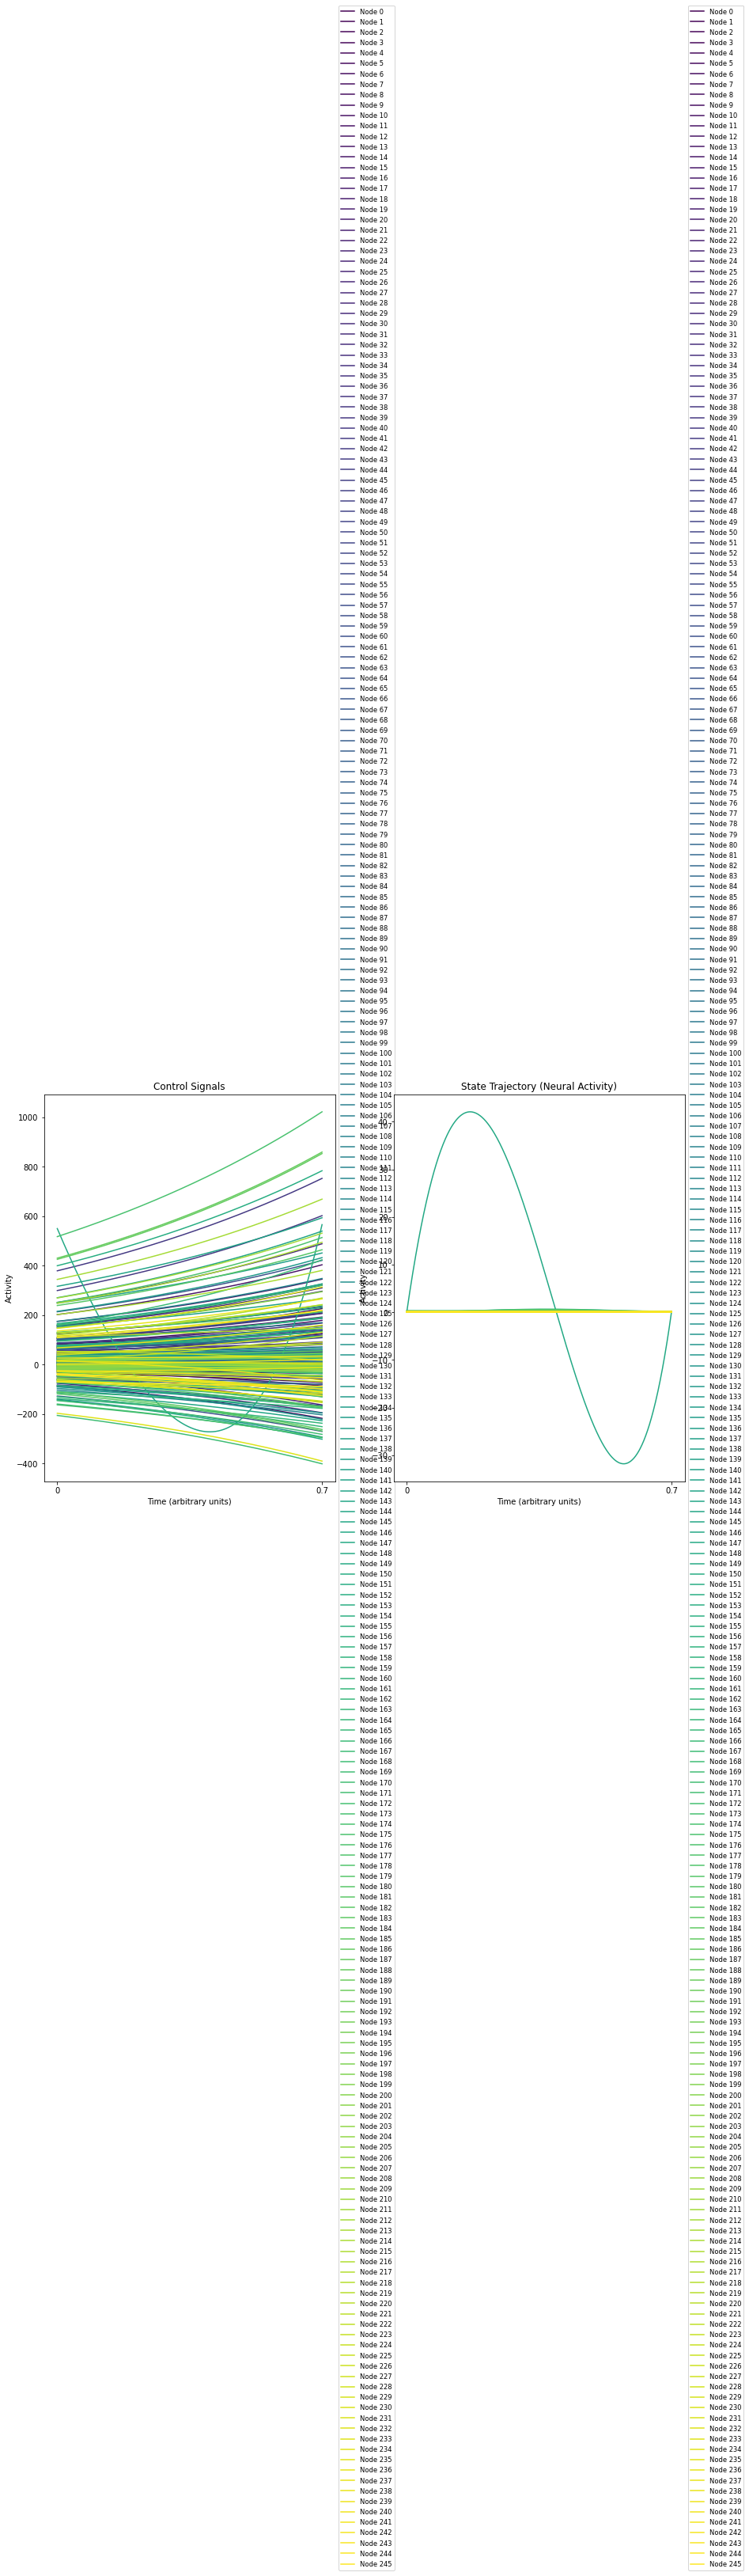

In [43]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/resting_state.txt')
n_nodes = A.shape[0]
B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[147, 147] = 1
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)
A_norm = matrix_normalization(A, system, c=gamma)
state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/state_control_signals_plot_initial_to_resting(147).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_initial_to_resting(147).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_initial_to_resting(147).txt", state_trajectory, delimiter=",")


inversion error = 1.99E-13 (<1.00E-08=True)
reconstruction error = 3.33E-10 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/457205951.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


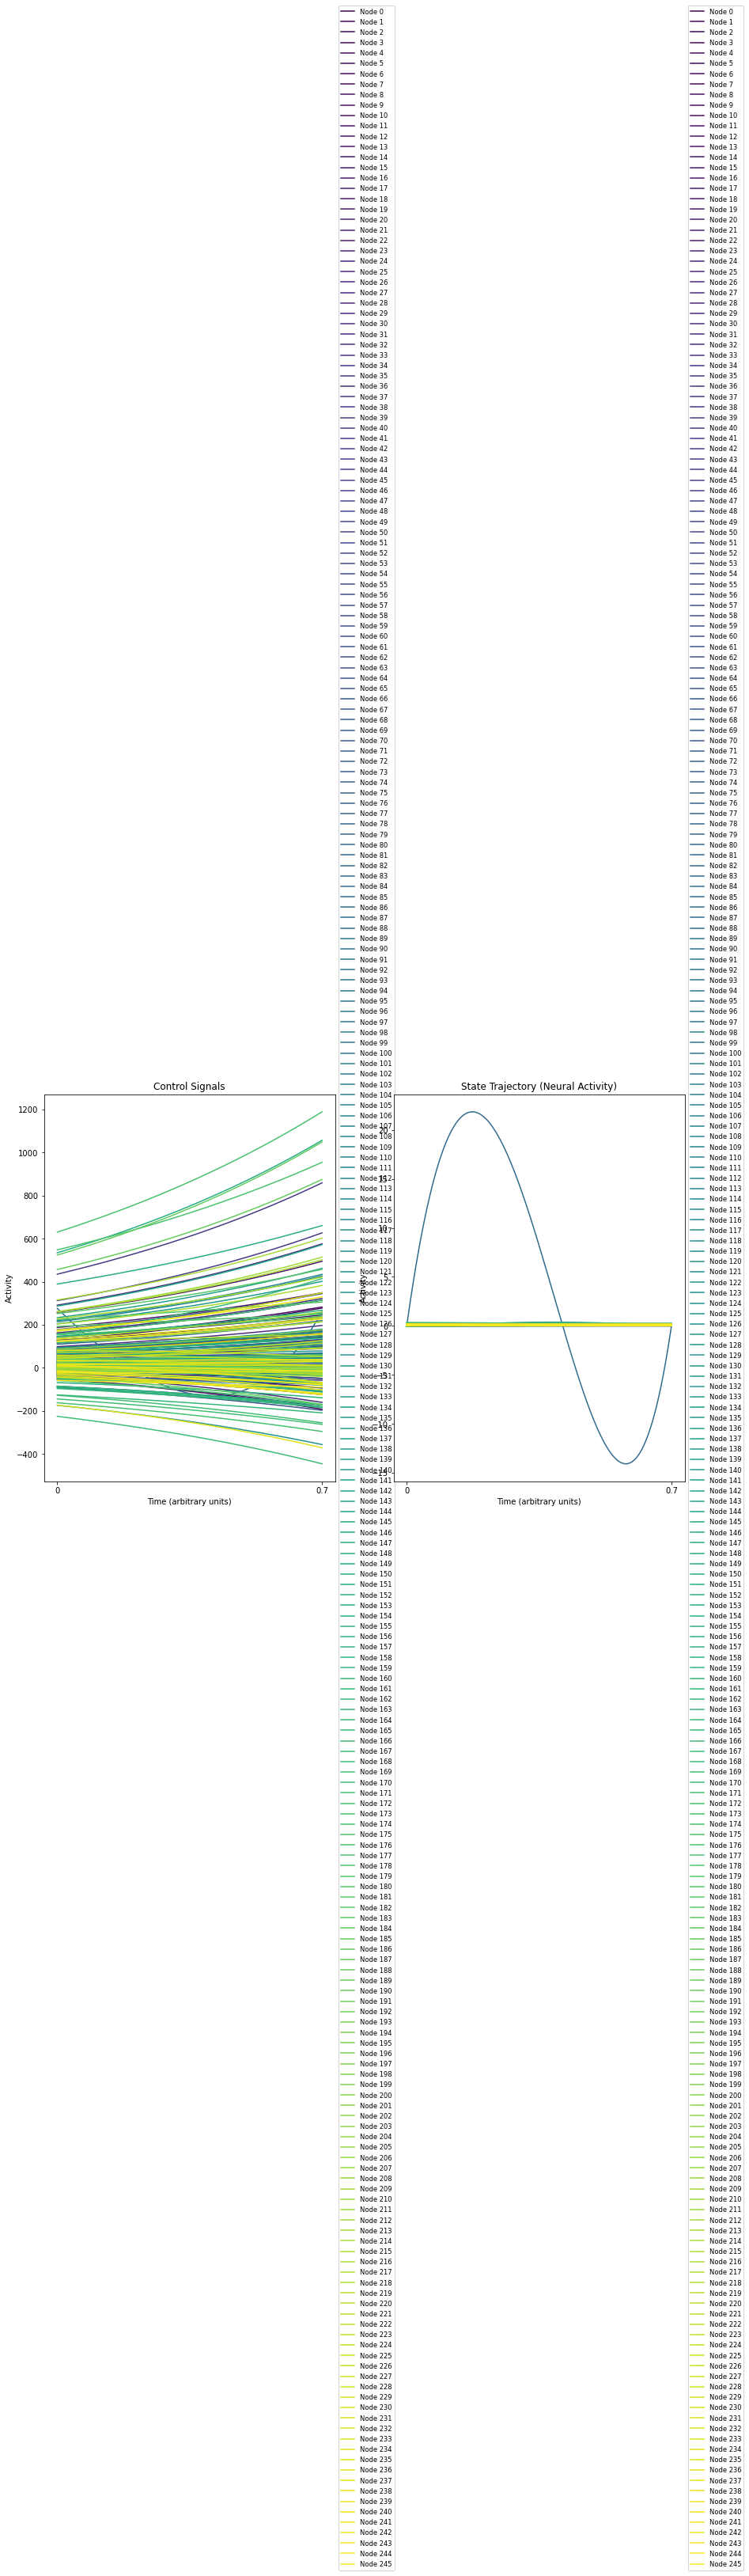

In [44]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/resting_state.txt')
n_nodes = A.shape[0]
B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[84, 84] = 1
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)
A_norm = matrix_normalization(A, system, c=gamma)
state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/state_control_signals_plot_initial_to_resting(84).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_initial_to_resting(84).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_initial_to_resting(84).txt", state_trajectory, delimiter=",")


inversion error = 9.29E-12 (<1.00E-08=True)
reconstruction error = 3.71E-10 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/1684594433.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


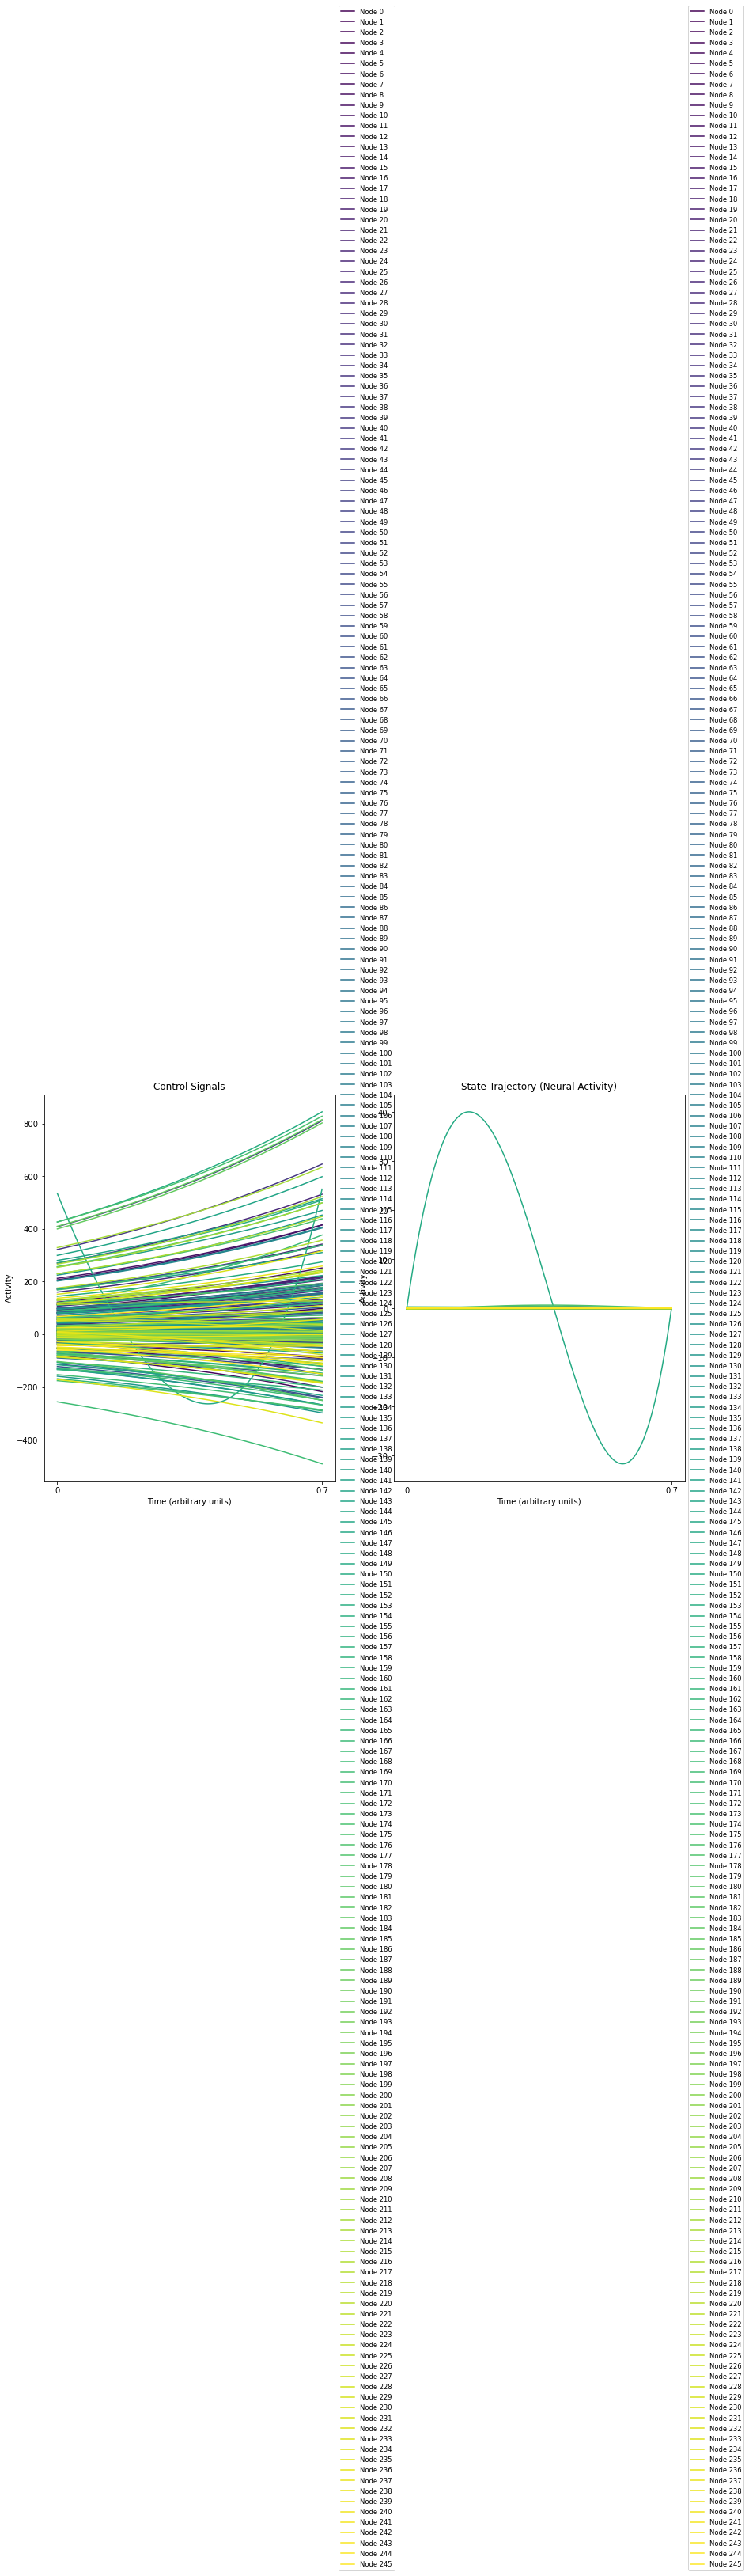

In [46]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/resting_state.txt')
n_nodes = A.shape[0]
B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[149, 149] = 1
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)
A_norm = matrix_normalization(A, system, c=gamma)
state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/state_control_signals_plot_initial_to_resting(149).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_initial_to_resting(149).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_initial_to_resting(149).txt", state_trajectory, delimiter=",")


inversion error = 2.53E-13 (<1.00E-08=True)
reconstruction error = 4.63E-11 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/3736041923.py:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


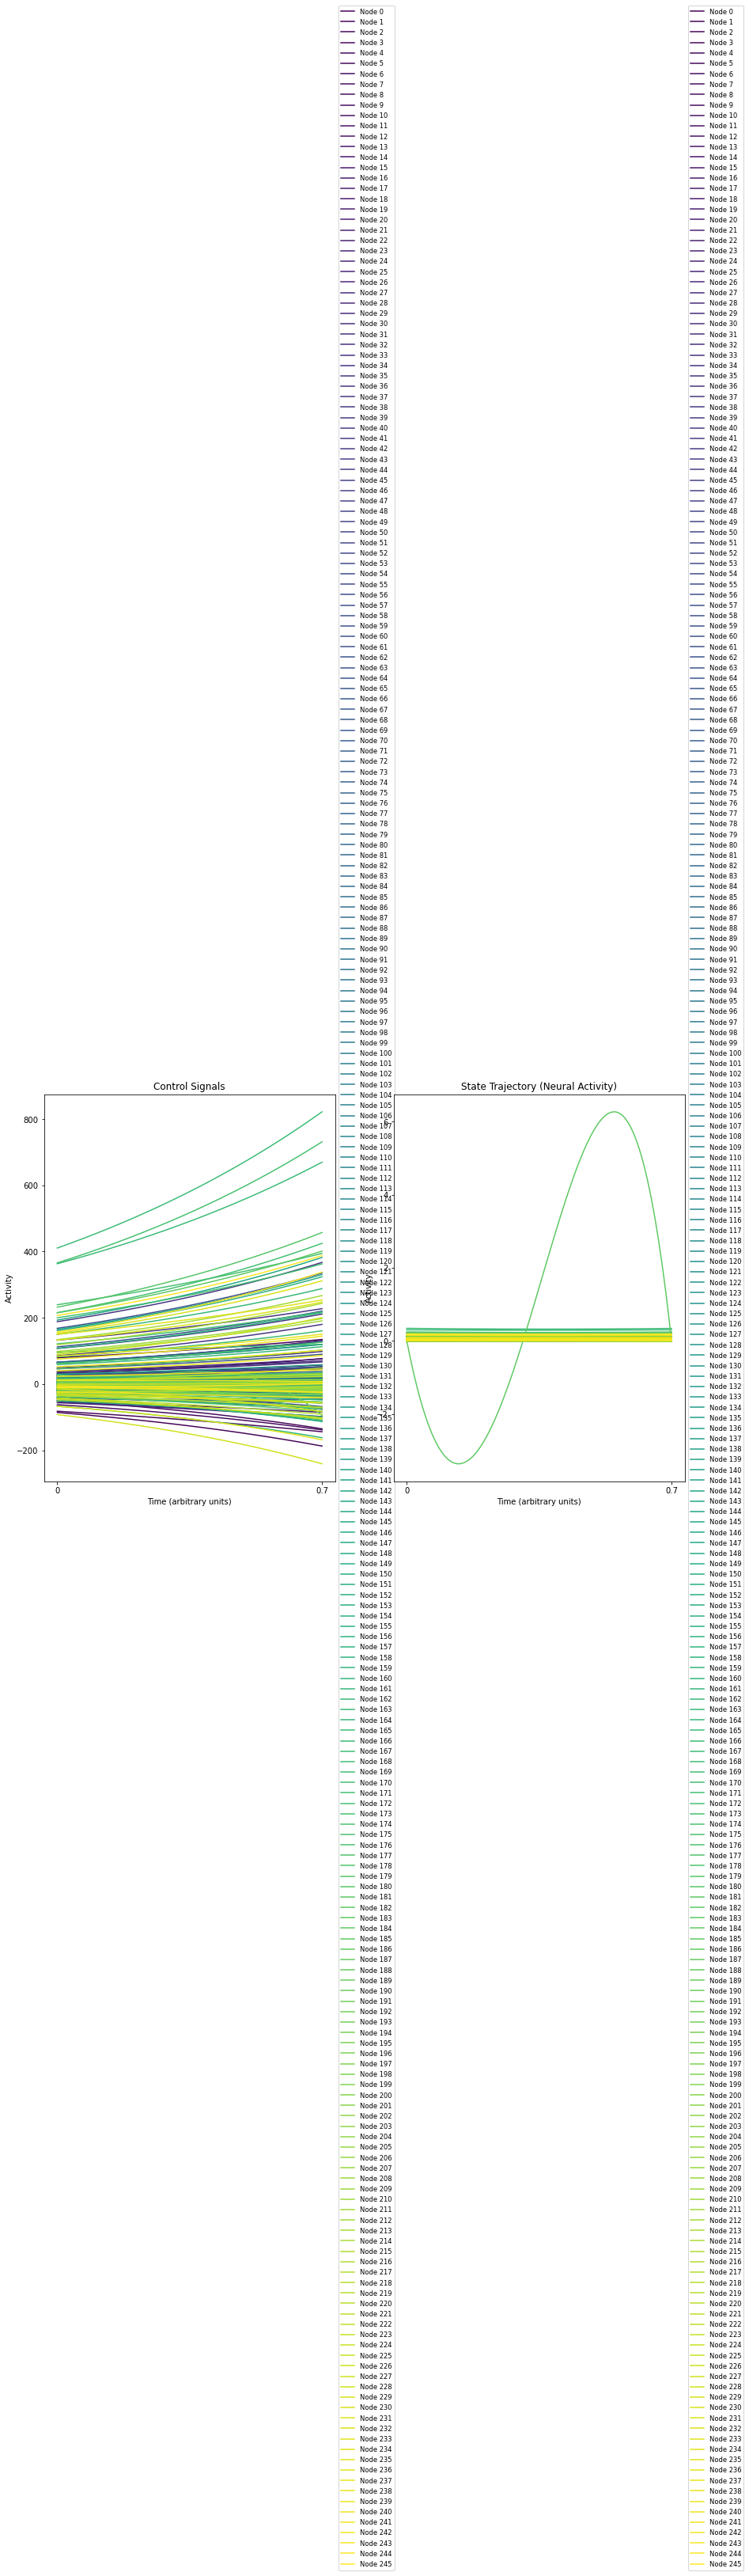

In [50]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
noise_std = 0.1 * np.mean(initial_state) 
noise = np.random.normal(0, noise_std, size=initial_state.shape)
target_state = initial_state + noise
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)
B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[184, 184] = 1
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)
A_norm = matrix_normalization(A, system, c=gamma)
state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/state_control_signals_plot_initial_to_pert(184).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_initial_to_pert(184).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_initial_to_pert(184).txt", state_trajectory, delimiter=",")

inversion error = 9.05E-14 (<1.00E-08=True)
reconstruction error = 1.38E-11 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/1175574487.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


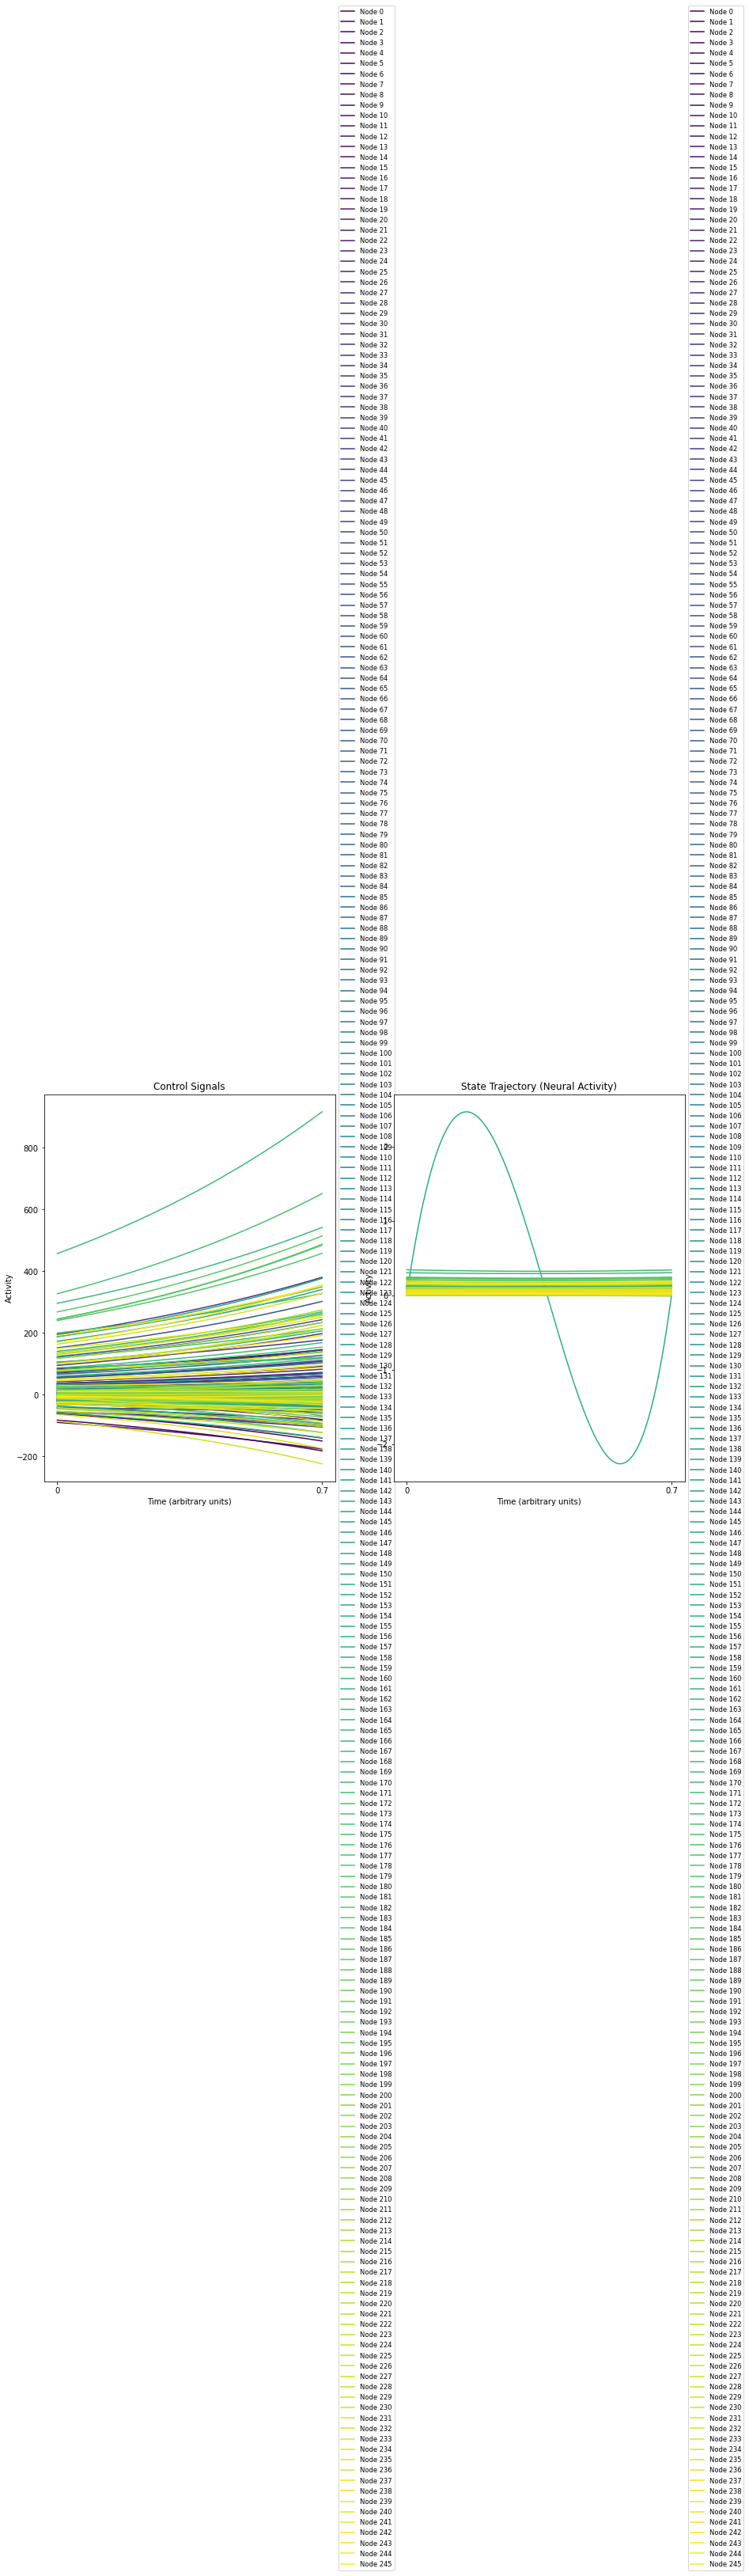

In [52]:
B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[155, 155] = 1
state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/state_control_signals_plot_initial_to_pert(155).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_initial_to_pert(155).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_initial_to_pert(155).txt", state_trajectory, delimiter=",")

inversion error = 4.12E-14 (<1.00E-08=True)
reconstruction error = 1.05E-12 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/1259907913.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


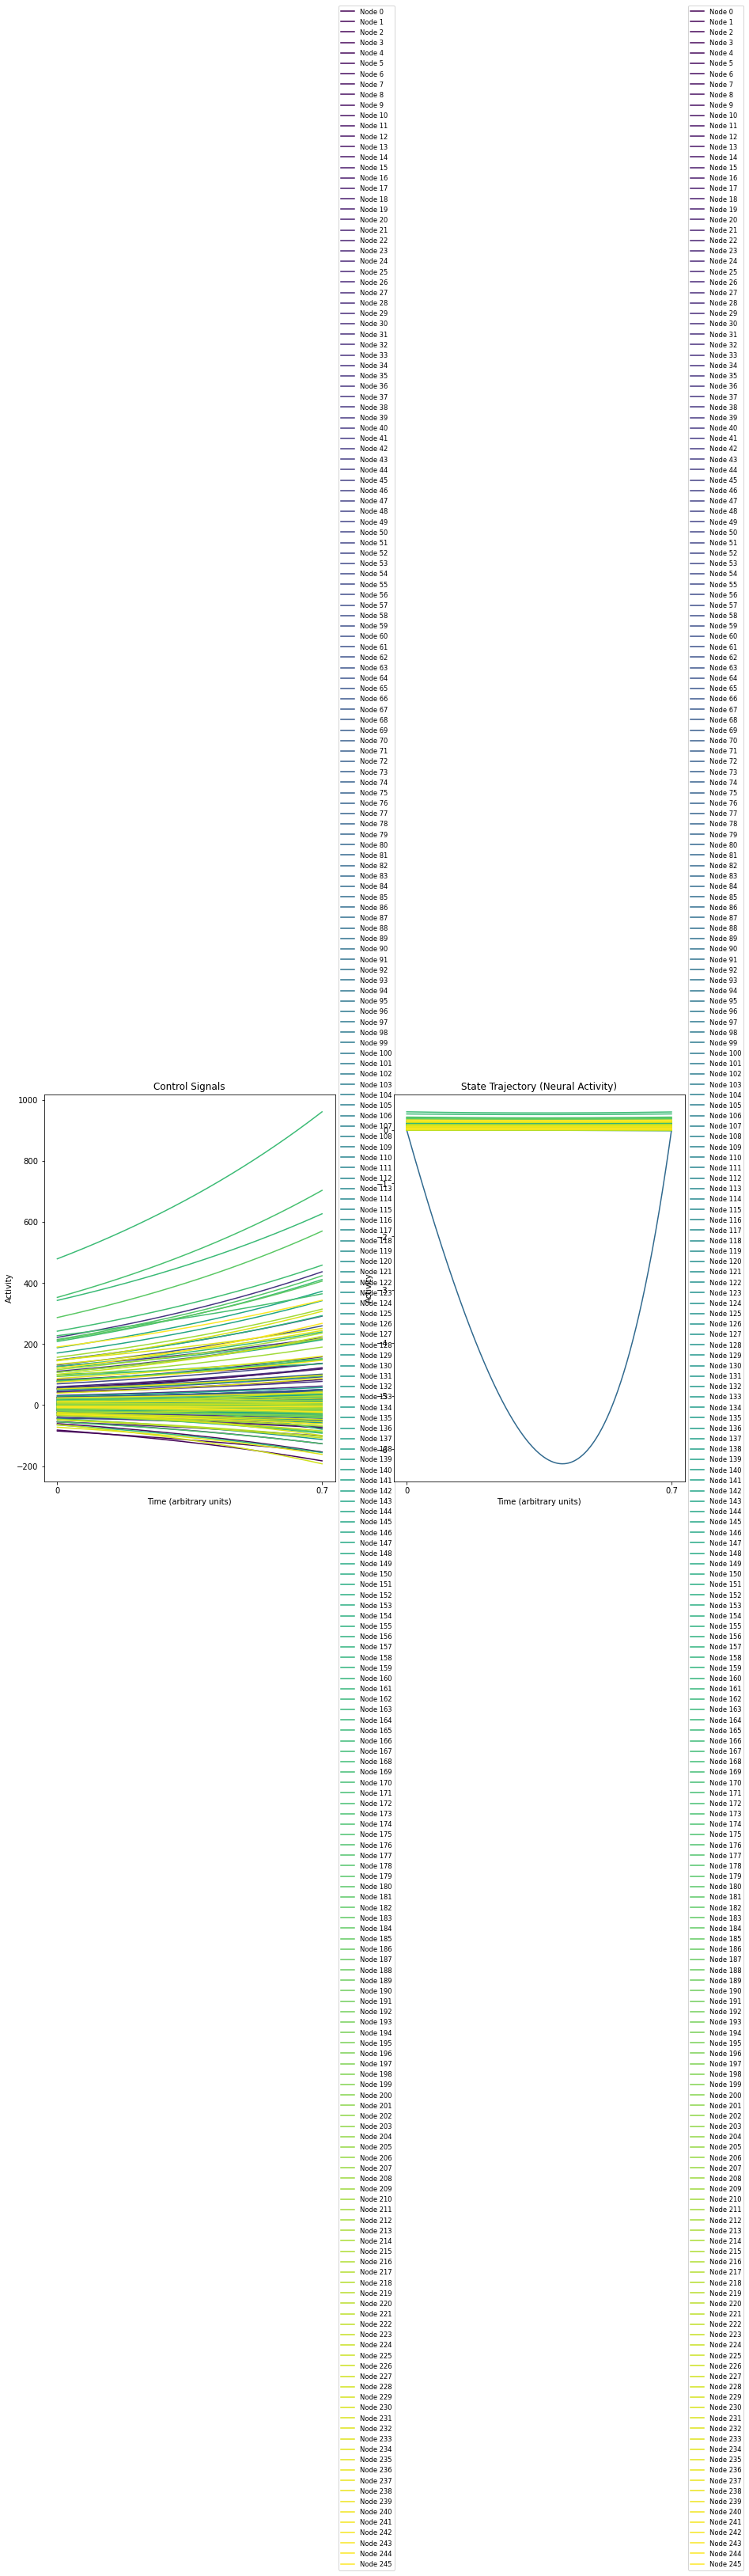

In [54]:
B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[83, 83] = 1
state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/state_control_signals_plot_initial_to_pert(83).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_initial_to_pert(83).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_initial_to_pert(83).txt", state_trajectory, delimiter=",")

inversion error = 9.96E-13 (<1.00E-08=True)
reconstruction error = 1.46E-10 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/1774658421.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


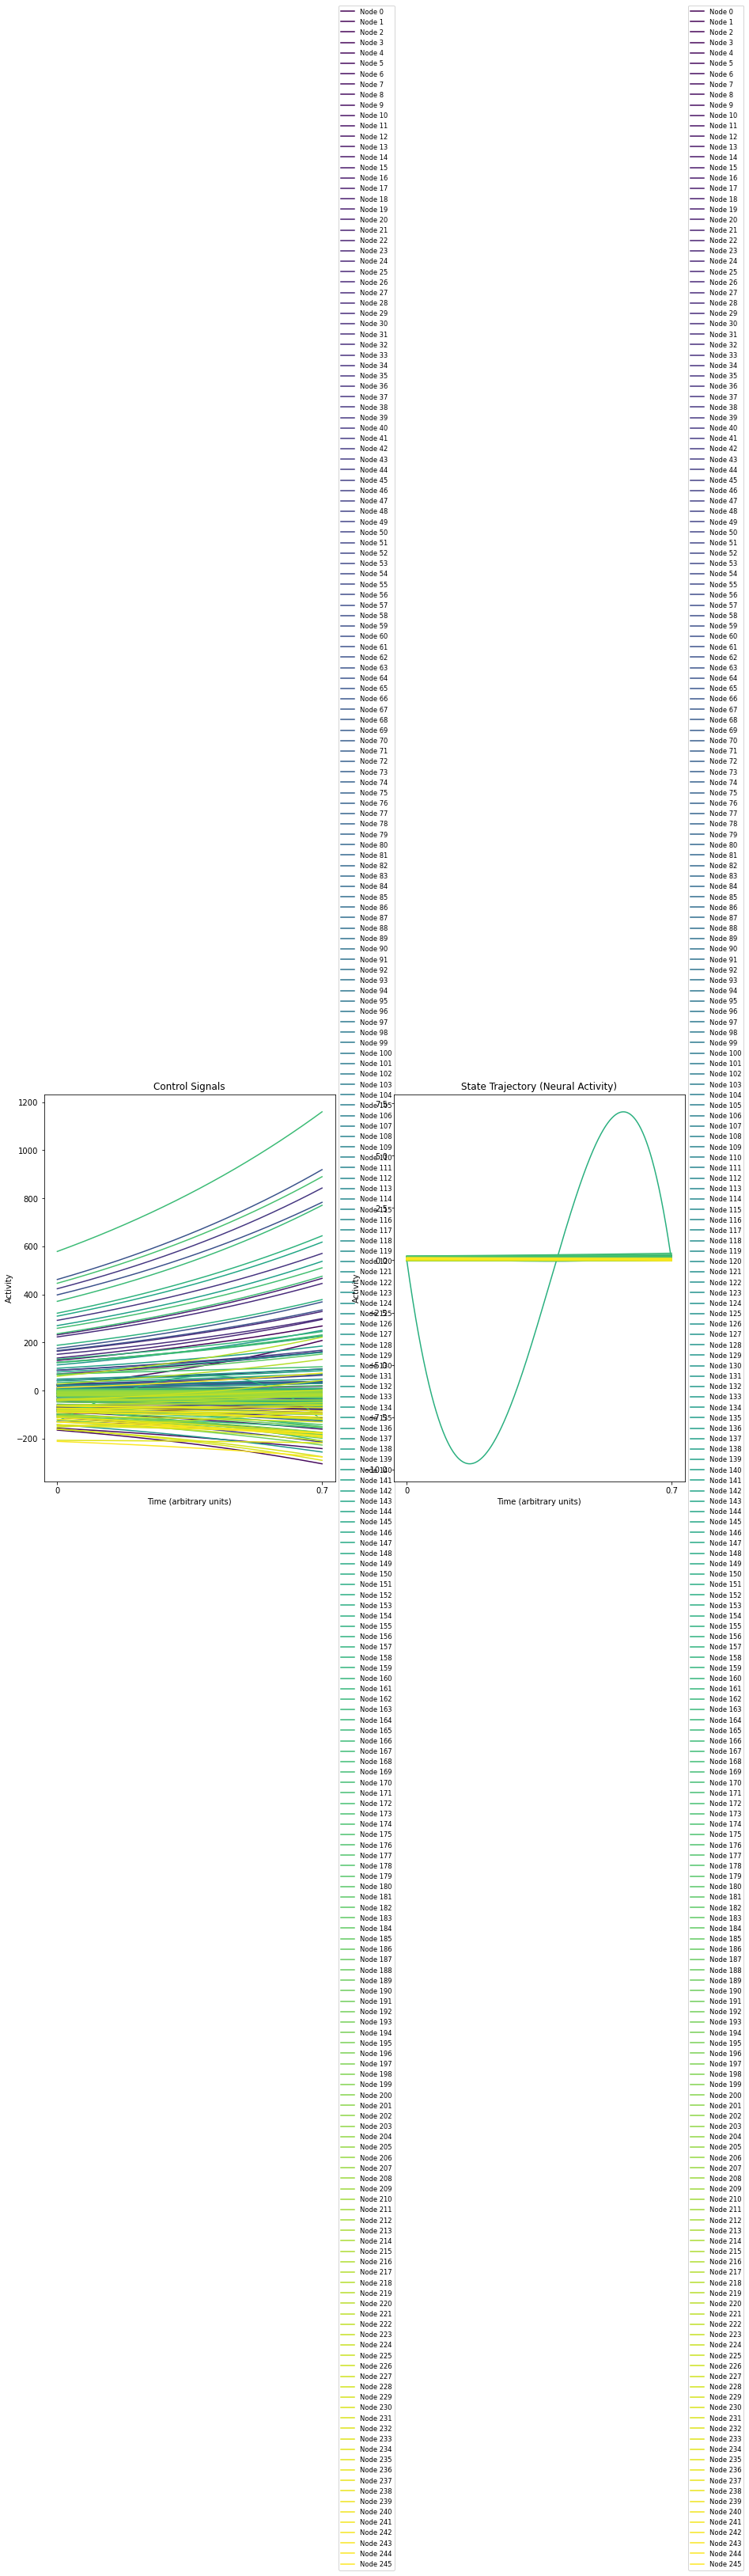

[[1.05691778e-01 1.11849914e-01 7.32721711e-03 ... 7.59796222e-02
  8.97283099e-02 1.22798376e-01]
 [1.05673644e-01 1.11853632e-01 7.34477663e-03 ... 7.58713794e-02
  8.95929271e-02 1.22733067e-01]
 [1.05655561e-01 1.11857384e-01 7.36224065e-03 ... 7.57631835e-02
  8.94575810e-02 1.22667813e-01]
 ...
 [1.10007470e-01 1.25285864e-01 1.10887176e-04 ... 7.55813744e-03
  4.43807497e-04 8.98932067e-02]
 [1.10046265e-01 1.25325115e-01 7.64751697e-05 ... 7.46497419e-03
  3.18349280e-04 8.98657358e-02]
 [1.10085182e-01 1.25364437e-01 4.20013596e-05 ... 7.37181077e-03
  1.92884145e-04 8.98383227e-02]]
First row: [1.05691778e-01 1.11849914e-01 7.32721711e-03 1.19973488e-03
 0.00000000e+00 0.00000000e+00 1.02507480e-01 9.03465333e-02
 1.02336038e-01 1.44438680e-01 3.54492134e-02 4.78580103e-02
 9.00999266e-04 0.00000000e+00 2.28859962e-02 2.64242557e-02
 8.94728418e-03 1.69775868e-02 1.29444187e-02 2.42913535e-02
 5.95241841e-02 1.15685530e-01 9.25074441e-04 3.34120693e-02
 6.03897375e-02 4.33618

In [65]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/high_pain.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/low_pain.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[155, 155] = 1

state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/state_control_signals_plot_high_to_low_pain(155).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_high_to_low_pain(155).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_high_to_low_pain(155).txt", state_trajectory, delimiter=",")
print(state_trajectory)
# 打印第一个行的元素

inversion error = 1.97E-13 (<1.00E-08=True)
reconstruction error = 1.38E-11 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/114249864.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


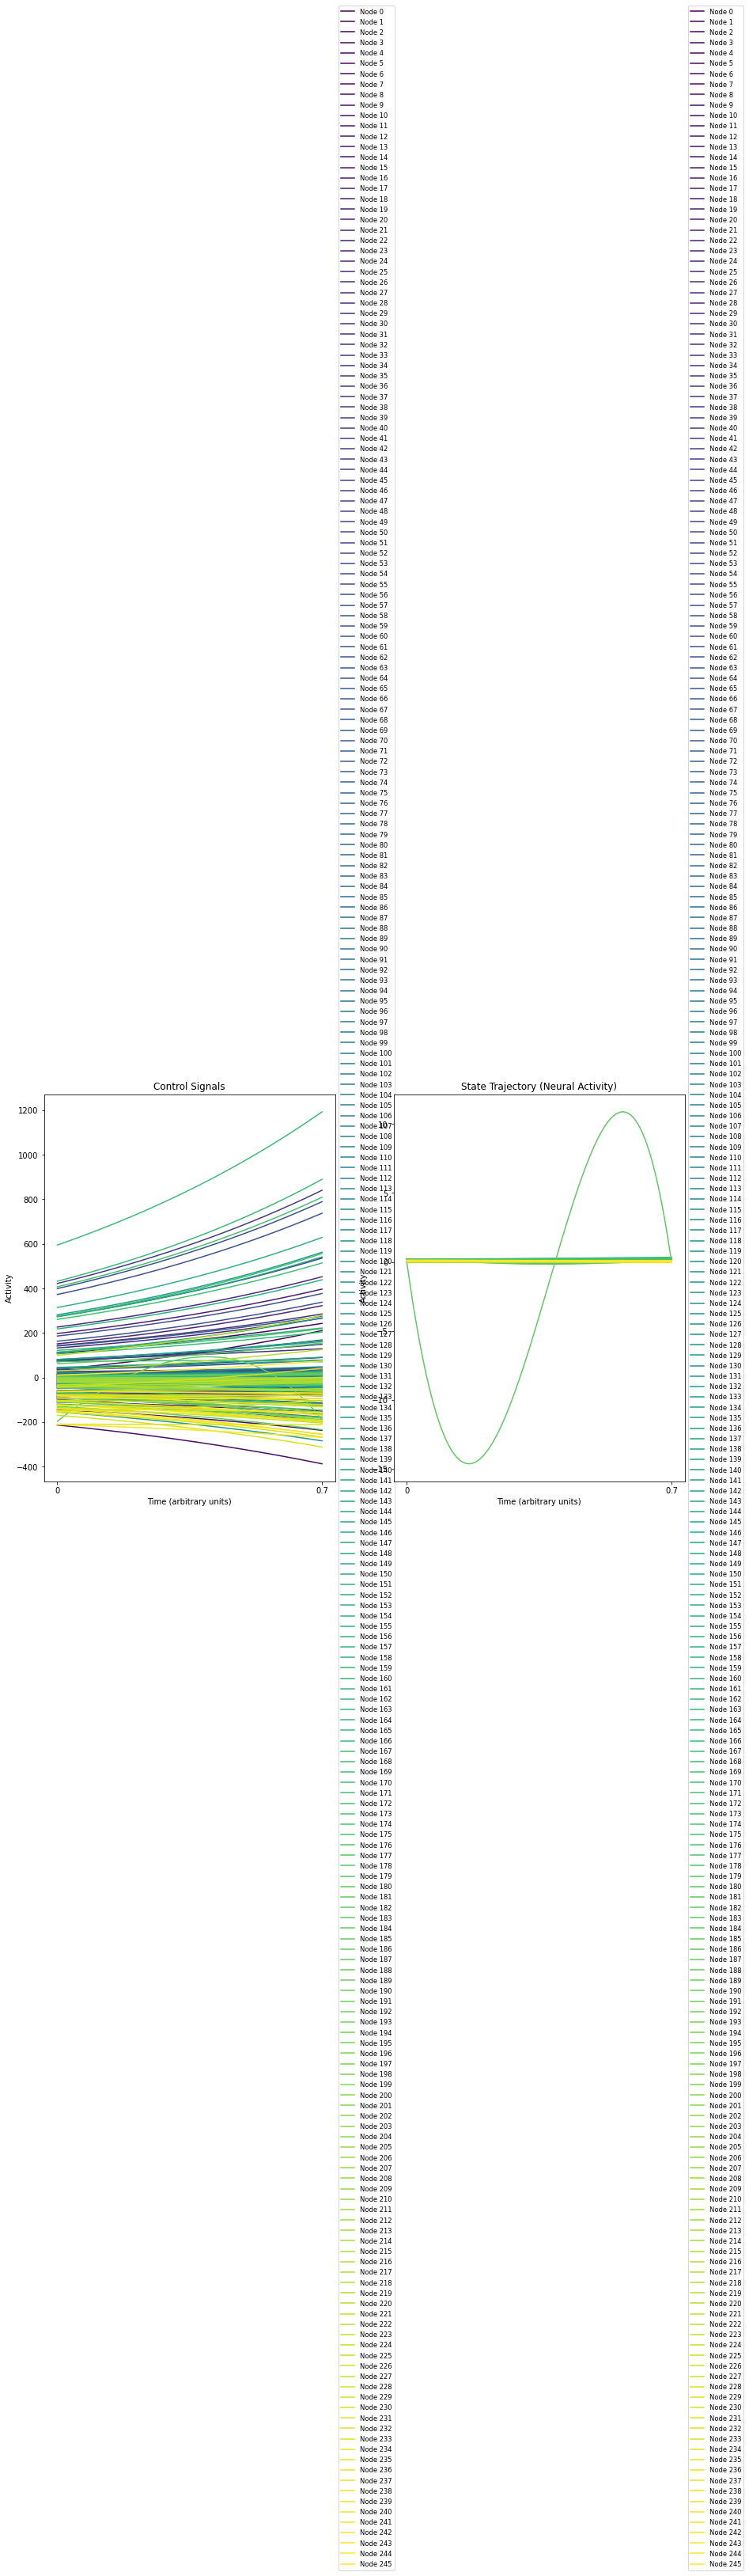

In [56]:
B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[184, 184] = 1

state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/state_control_signals_plot_high_to_low_pain(184).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_high_to_low_pain(184).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_high_to_low_pain(184).txt", state_trajectory, delimiter=",")


inversion error = 8.88E-14 (<1.00E-08=True)
reconstruction error = 3.00E-12 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/599669541.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


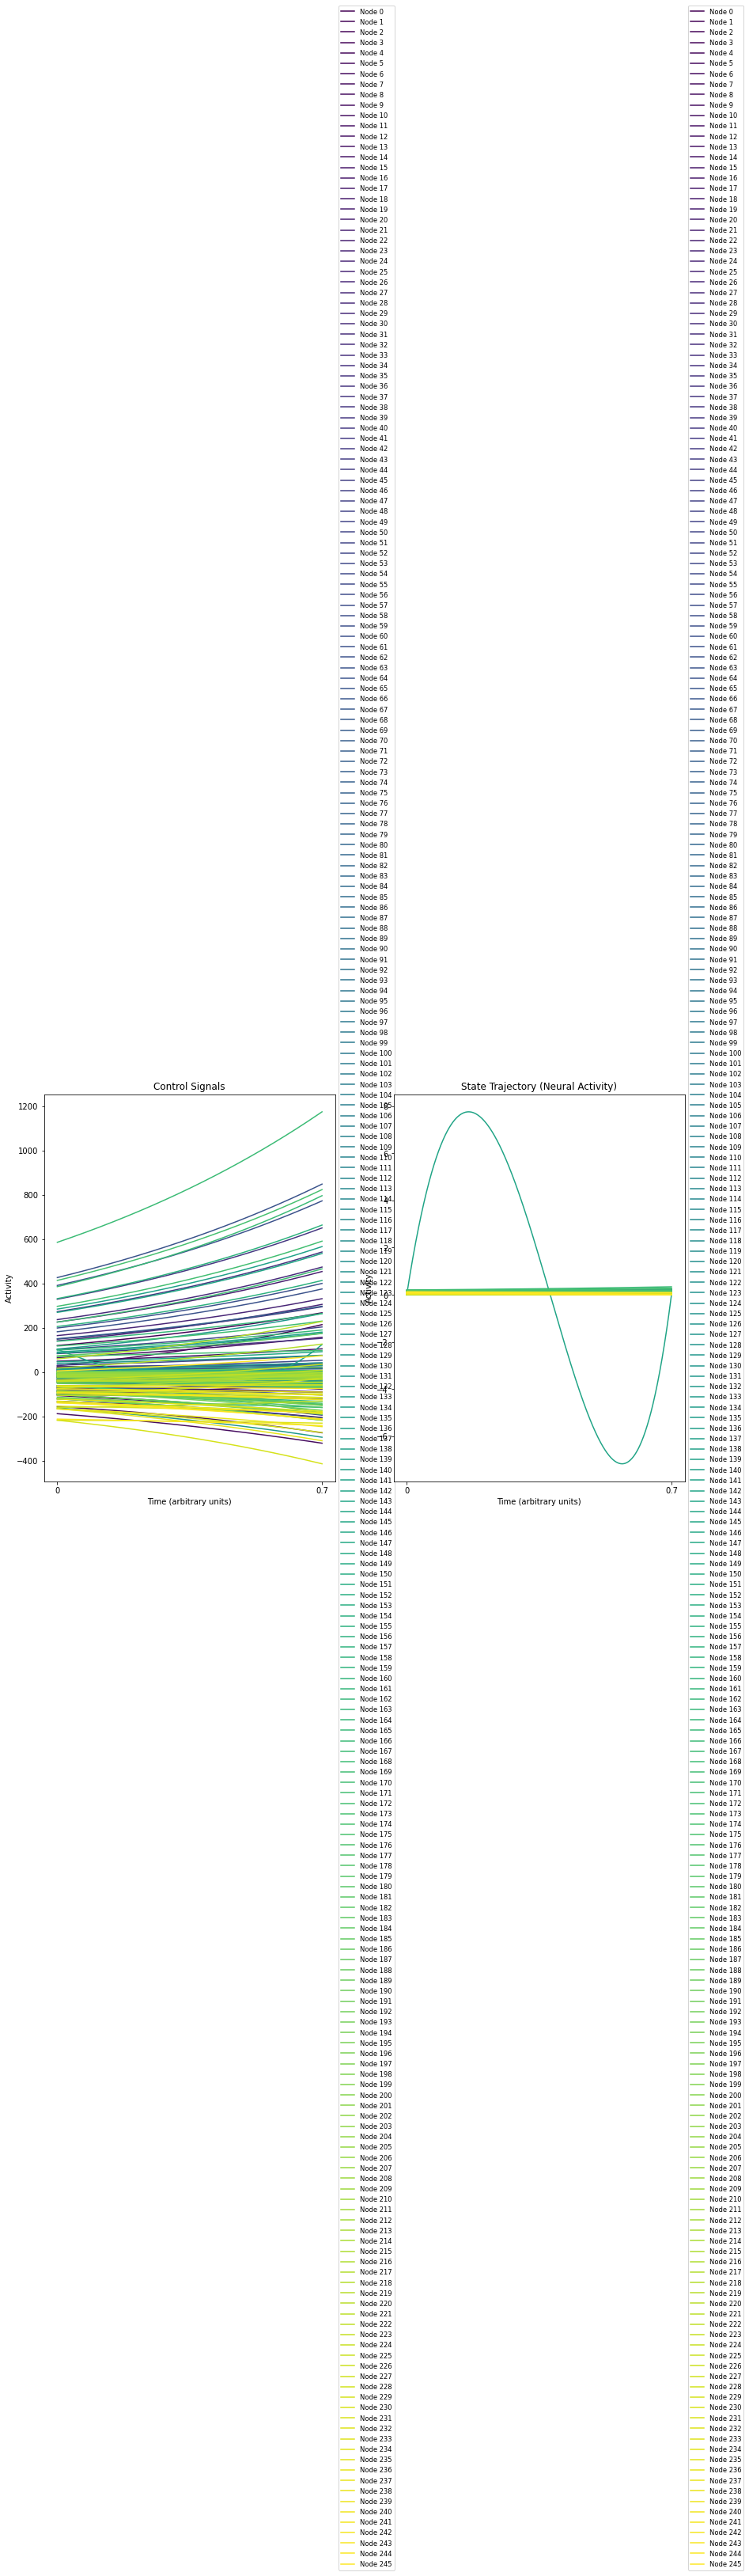

In [57]:
B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[143, 143] = 1

state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/state_control_signals_plot_high_to_low_pain(143).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_high_to_low_pain(143).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_high_to_low_pain(143).txt", state_trajectory, delimiter=",")


inversion error = 1.30E-11 (<1.00E-08=True)
reconstruction error = 6.27E-11 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/1594729112.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


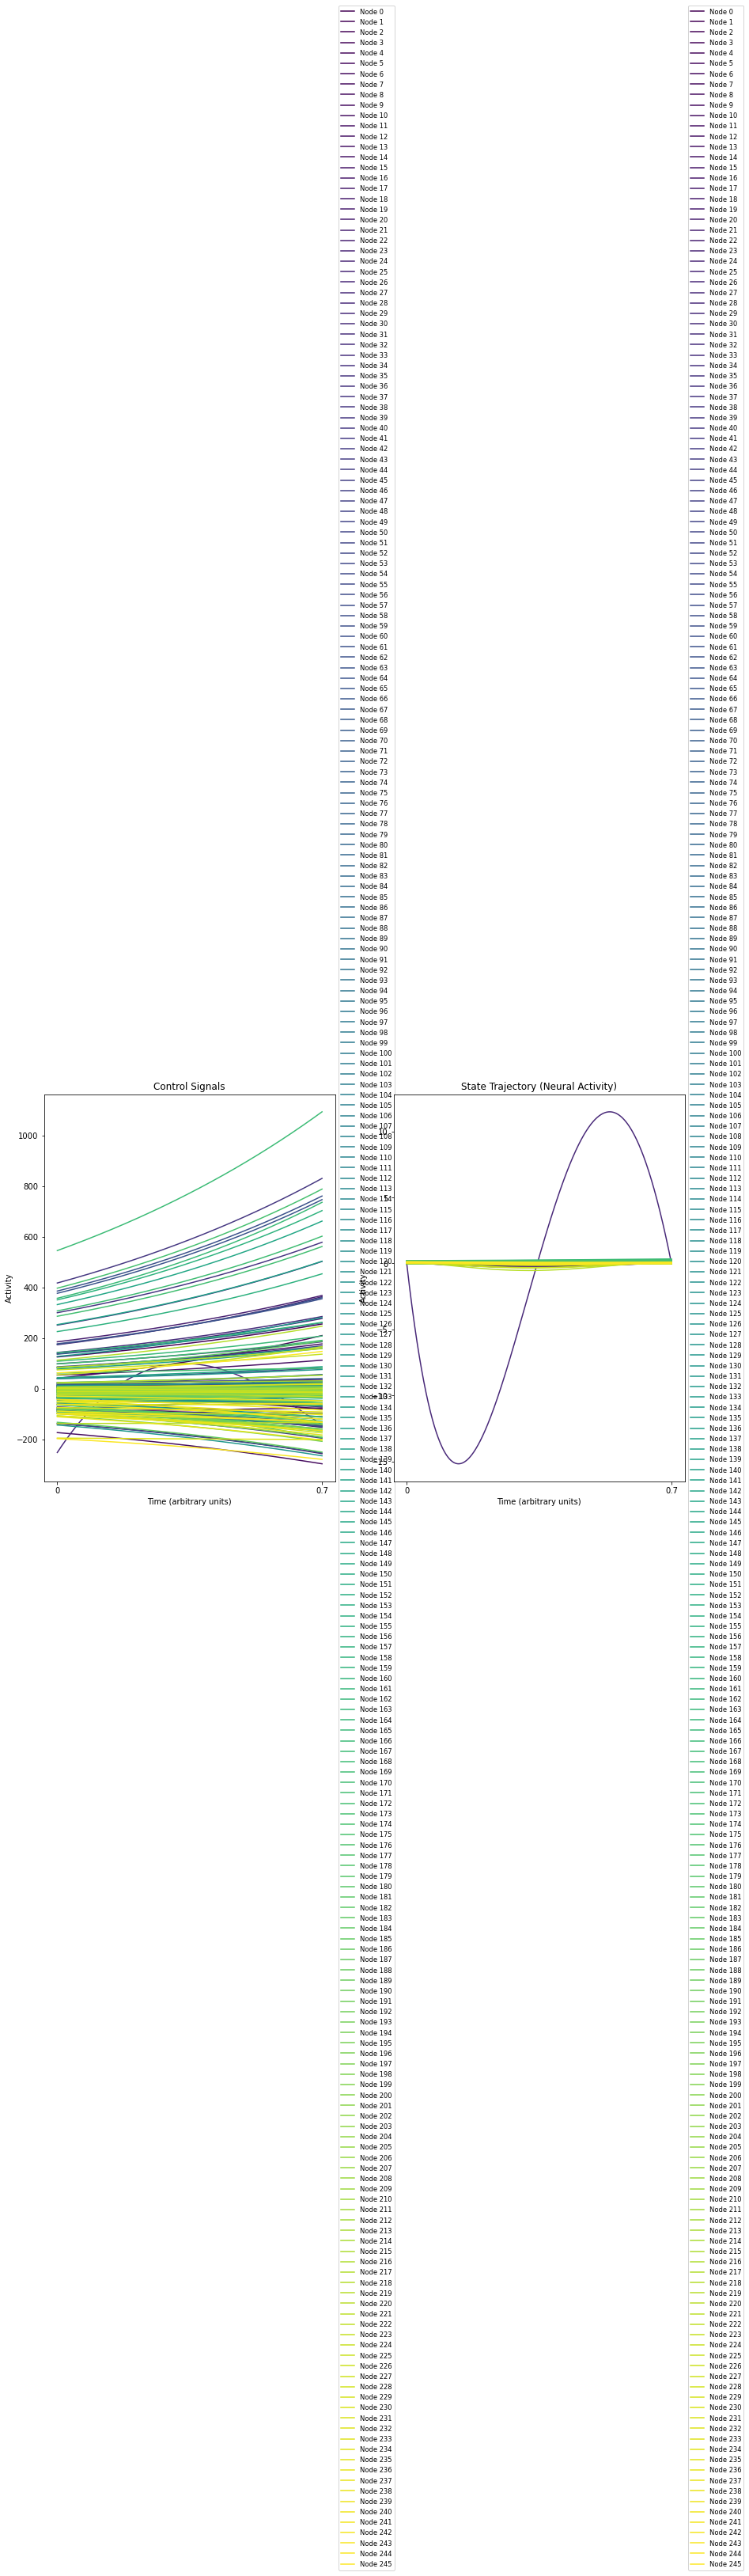

In [58]:
B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[27, 27] = 1

state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/state_control_signals_plot_high_to_low_pain(27).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_high_to_low_pain(27).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_high_to_low_pain(27).txt", state_trajectory, delimiter=",")


inversion error = 9.09E-14 (<1.00E-08=True)
reconstruction error = 2.27E-10 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/2751176280.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


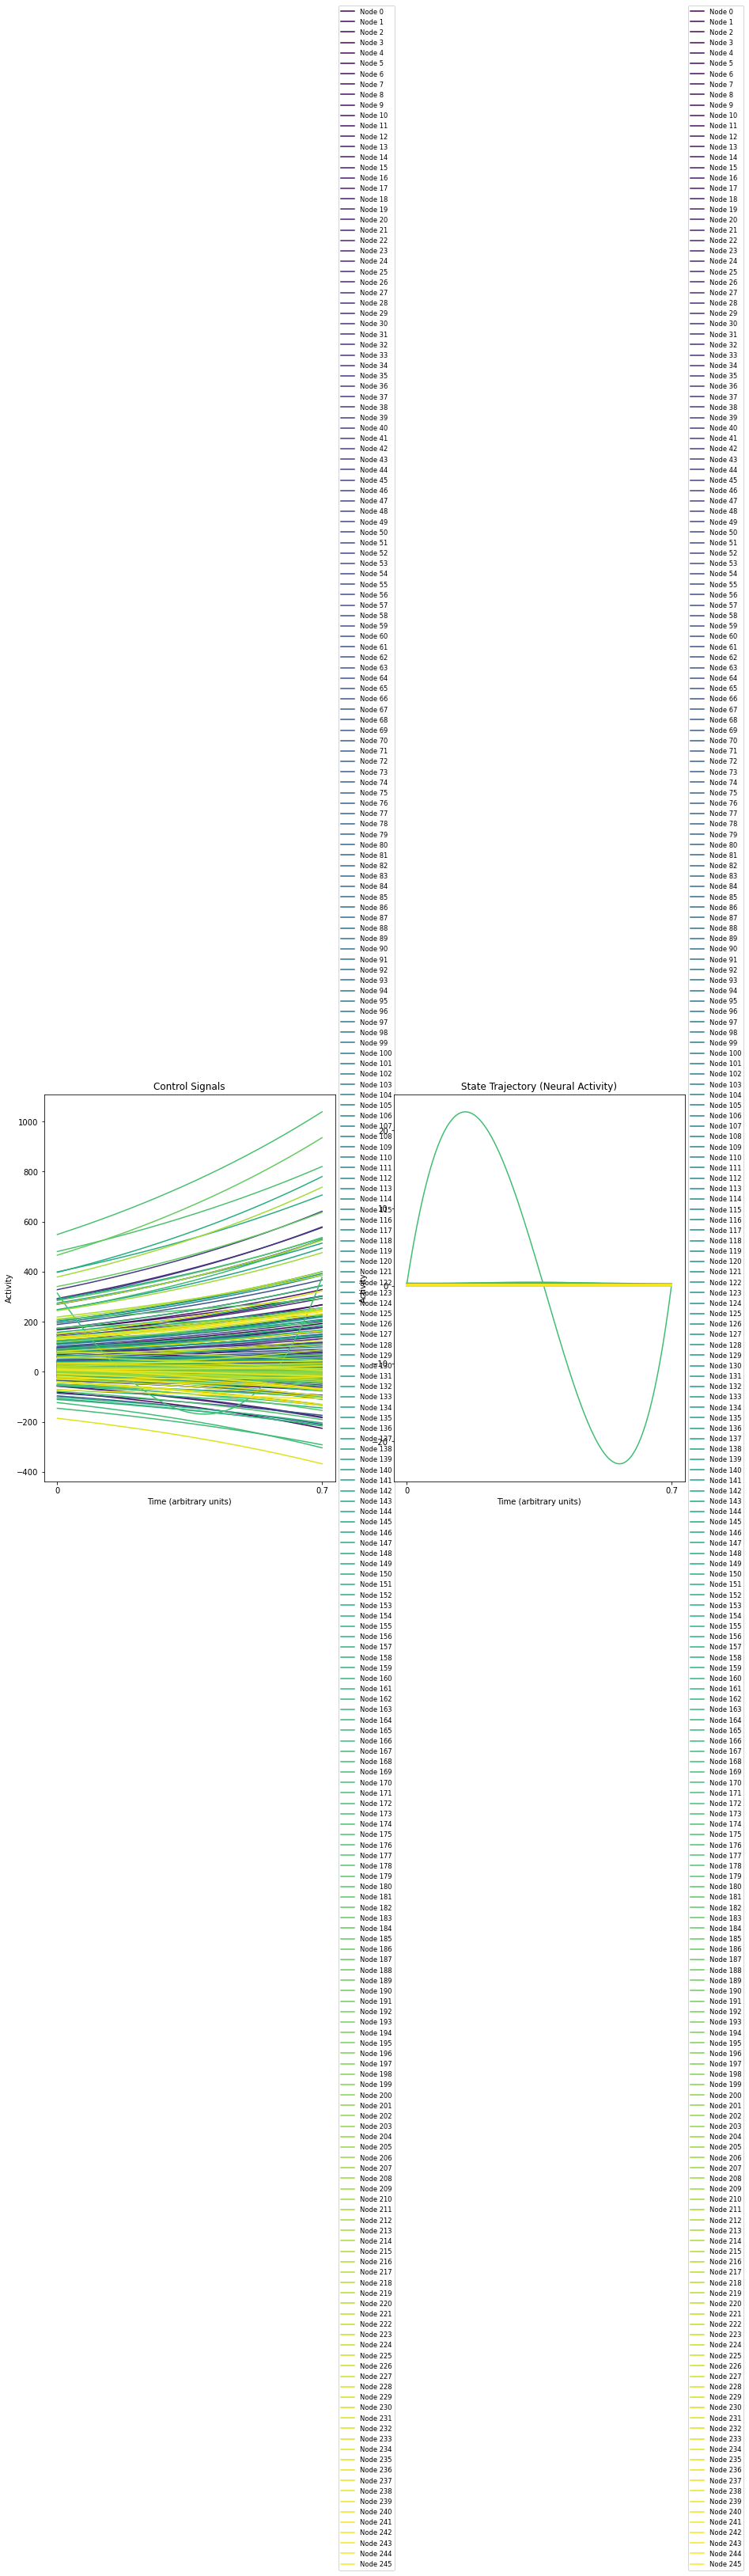

In [60]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/resting_state.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[170, 170] = 1

state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/target2/state_control_signals_plot_initial_to_resting(170).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/target2/control_signals_initial_to_resting(170).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/target2/state_trajectory_initial_to_resting(170).txt", state_trajectory, delimiter=",")


inversion error = 9.04E-14 (<1.00E-08=True)
reconstruction error = 8.28E-12 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/2965414951.py:68: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


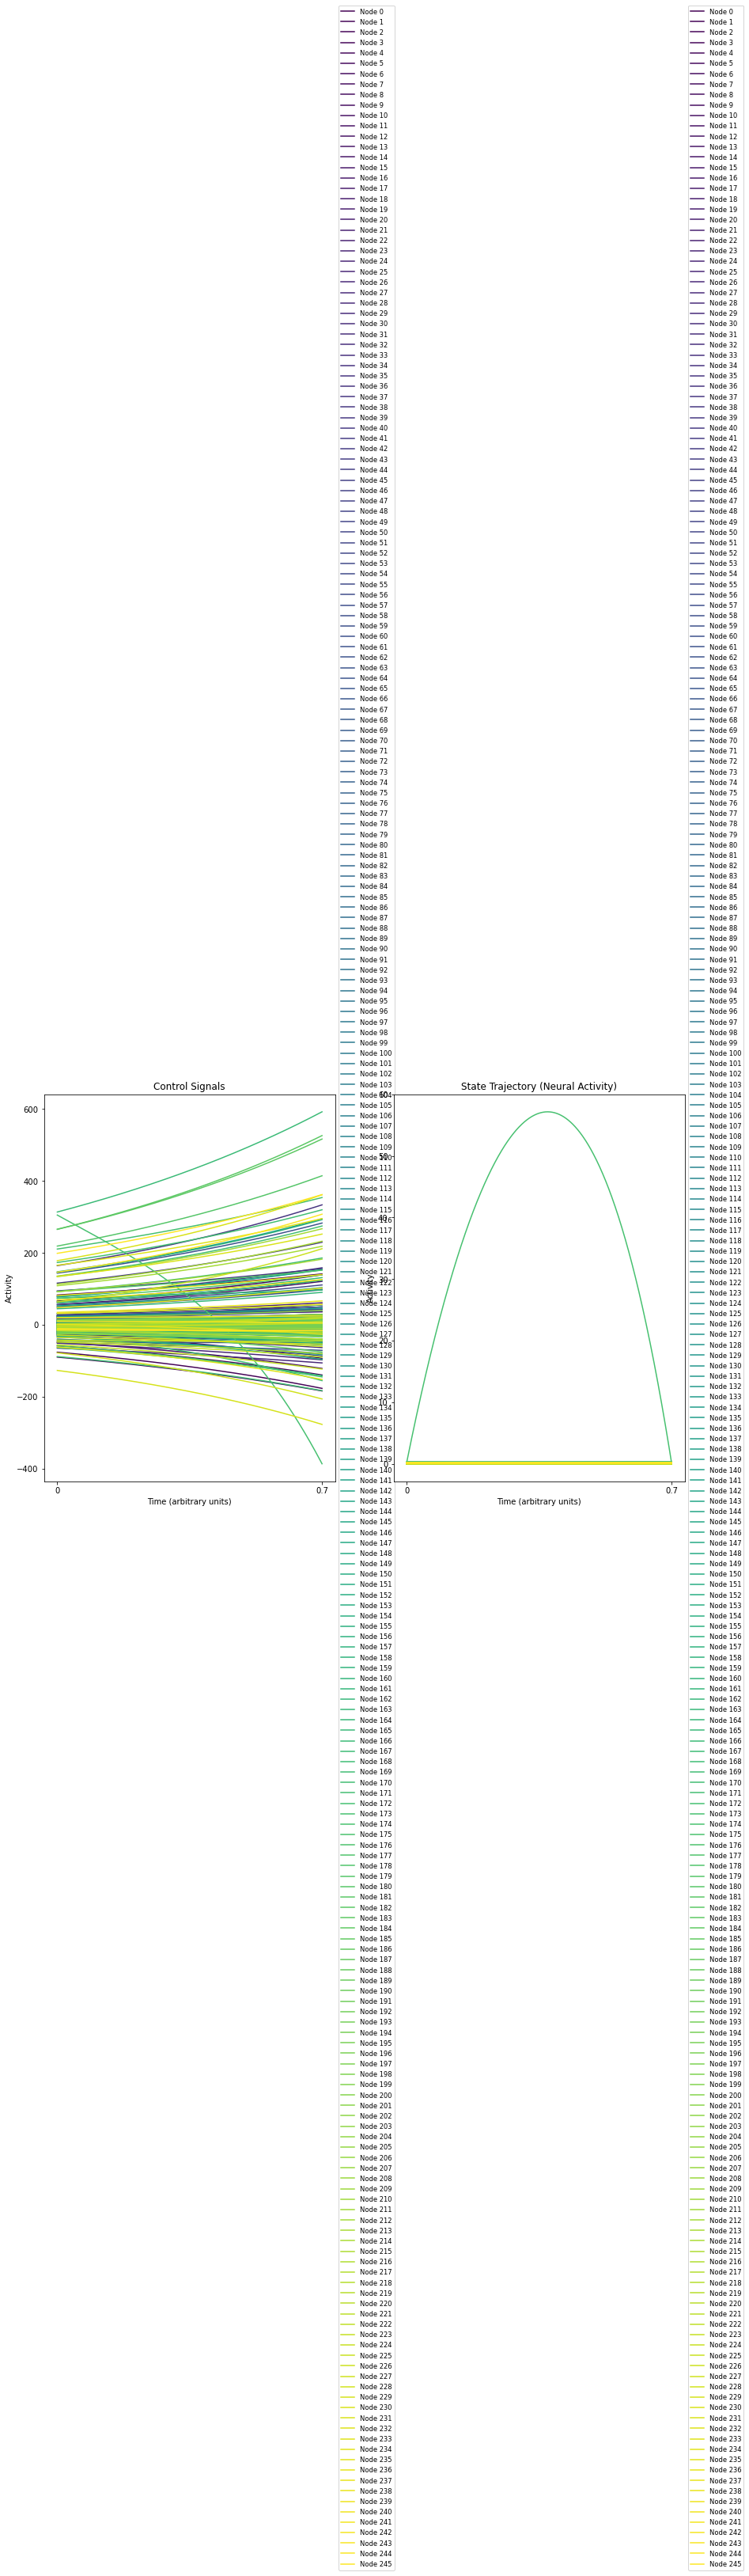

In [61]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
noise_std = 0.1 * np.mean(initial_state) 
noise = np.random.normal(0, noise_std, size=initial_state.shape)
target_state = initial_state + noise
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[173, 173] = 1

state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/target2/state_control_signals_plot_initial_to_pert(173).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/target2/control_signals_initial_to_pert(173).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/target2/state_trajectory_initial_to_pert(173).txt", state_trajectory, delimiter=",")


inversion error = 7.25E-13 (<1.00E-08=True)
reconstruction error = 9.85E-12 (<1.00E-08=True)


/var/folders/5h/x_p7ky7d4ts4dz4c7g75h28c0000gn/T/ipykernel_85413/1525679369.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  f.tight_layout()


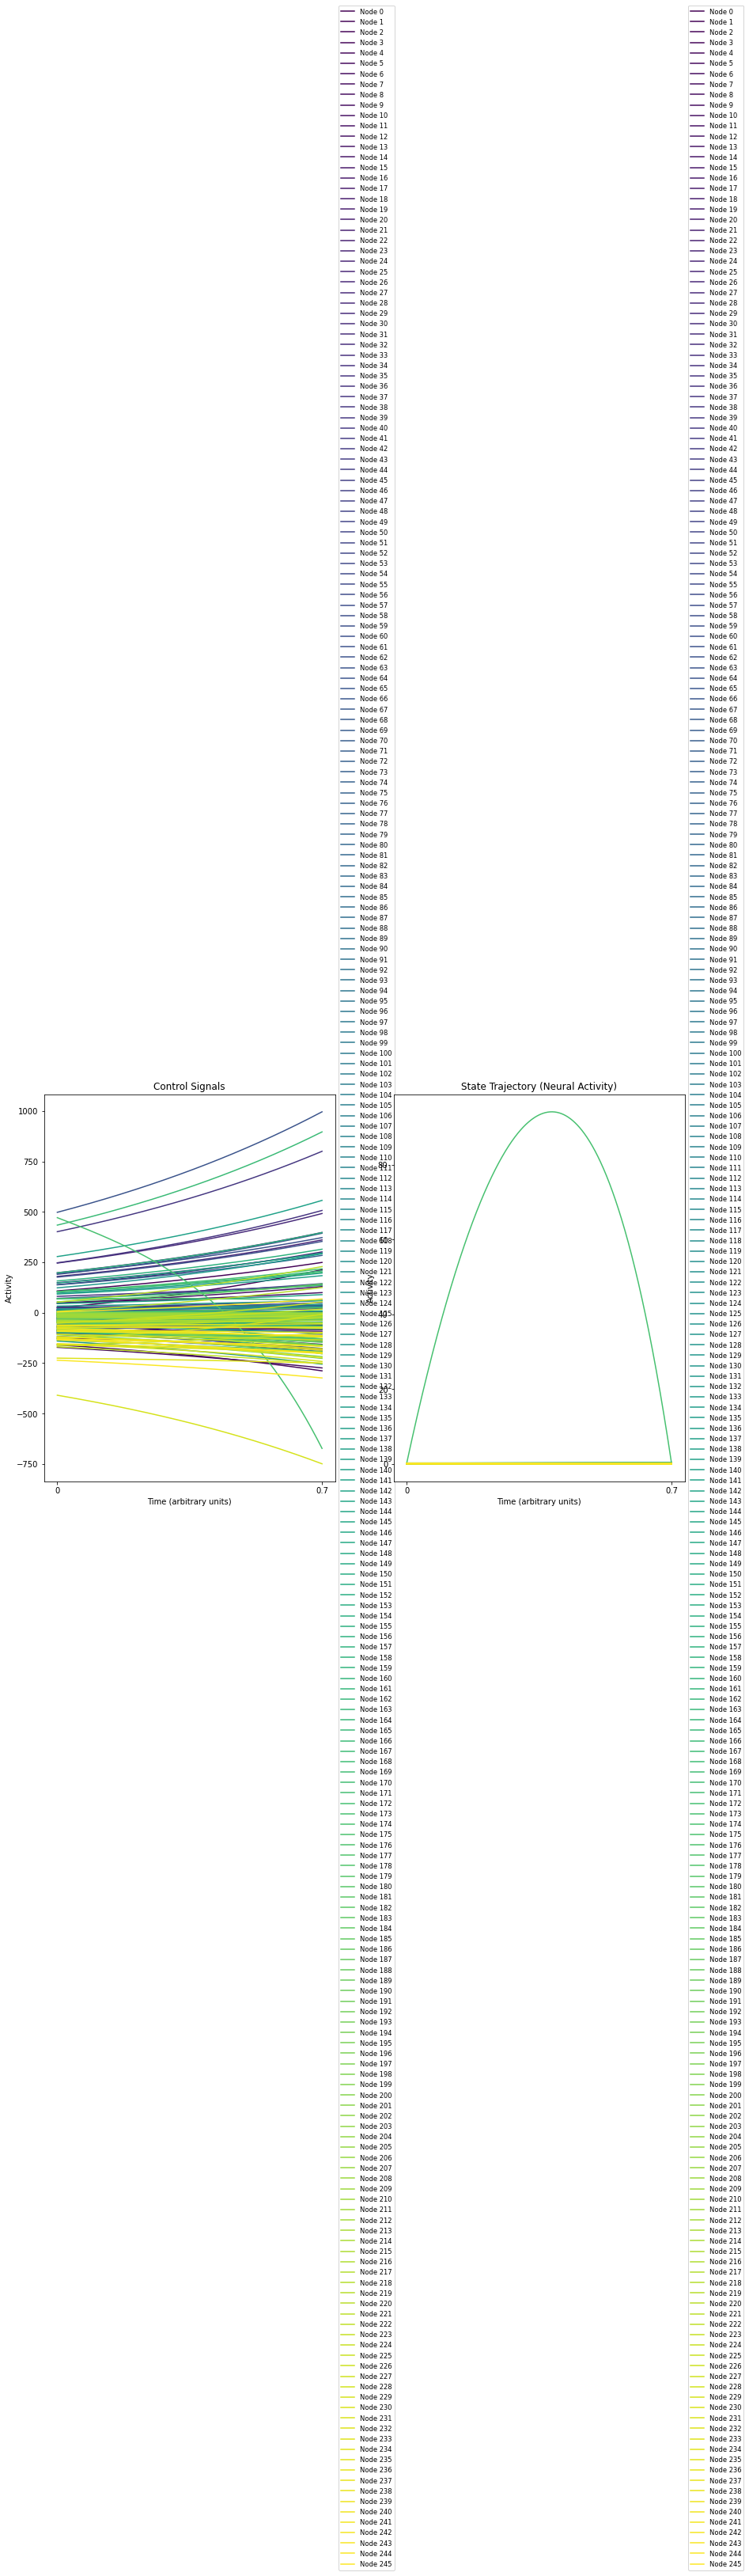

In [62]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/high_pain.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/low_pain.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[173, 173] = 1

state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

# 生成节点颜色
colors = plt.cm.viridis(np.linspace(0, 1, control_signals.shape[1]))

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制控制信号
for i in range(control_signals.shape[1]):
    ax[0].plot(control_signals[:, i], label=f'Node {i}', color=colors[i])
ax[0].set_title('Control Signals')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")

# 绘制状态轨迹
for i in range(state_trajectory.shape[1]):
    ax[1].plot(state_trajectory[:, i], label=f'Node {i}', color=colors[i])
ax[1].set_title('State Trajectory (Neural Activity)')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0] - 1])
    cax.set_xticklabels([0, T])

# 添加图例，设置图例在图形外部
plt.subplots_adjust(right=0.75)  # 调整子图布局
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


f.tight_layout()
plt.savefig("/Users/shenxiaoyu/Desktop/NCT/target2/state_control_signals_plot_high_low_pain(173).pdf")
plt.show()


np.savetxt("/Users/shenxiaoyu/Desktop/NCT/target2/control_signals_high_low_pain(173).txt" , control_signals, delimiter=",")
# 保存 state_trajectory 到文本文件
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/target2/state_trajectory_high_low_pain(173).txt", state_trajectory, delimiter=",")


In [64]:
state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/target2/control_signals_high_low_pain(173).txt', delimiter=",")
print(state.shape)

(701, 246)


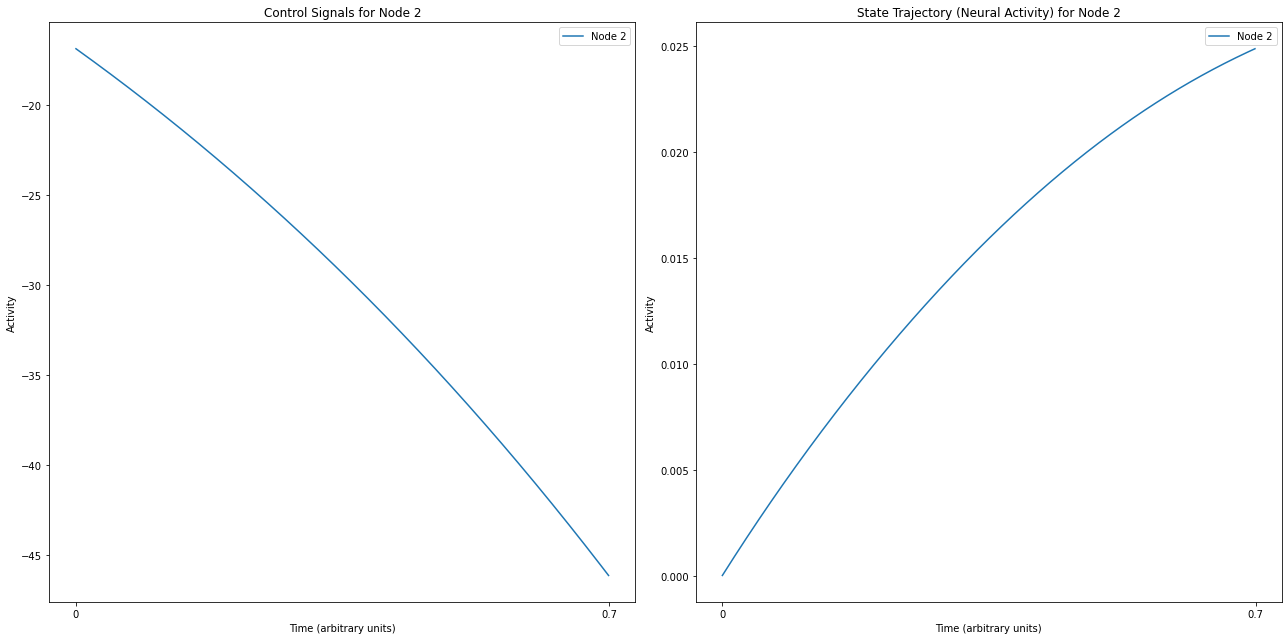

In [35]:
# 节点 2 的索引是 2
node_index = 2

# 可视化 state trajectory (x) 和 control signals (u) 
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# 绘制节点 2 的控制信号
ax[0].plot(control_signals[:, node_index], label=f'Node {node_index}')
ax[0].set_title('Control Signals for Node 2')
ax[0].set_xlabel("Time (arbitrary units)")
ax[0].set_ylabel("Activity")
ax[0].legend(loc='upper right')

# 绘制节点 2 的状态轨迹
ax[1].plot(state_trajectory[:, node_index], label=f'Node {node_index}')
ax[1].set_title('State Trajectory (Neural Activity) for Node 2')
ax[1].set_xlabel("Time (arbitrary units)")
ax[1].set_ylabel("Activity")
ax[1].legend(loc='upper right')

# 设置x轴的刻度和标签
for cax in ax:
    cax.set_xticks([0, state_trajectory.shape[0]])
    cax.set_xticklabels([0, T])

# 调整图形布局
f.tight_layout()

# 显示图形
plt.show()

# 2 simulation point

In [47]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/high_pain.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/low_pain.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

results_high_low_pain_2 = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 2,
    numerical_threshold=1
)

with open('/Users/shenxiaoyu/Desktop/NCT/high_low_pain(2 point).txt', 'w') as file:
    for result in results_high_low_pain_2:
        output_line = f"Stimulation Point: {result['combination']}, Energy: {result['energy']}, Error: {result['error']}\n"
        file.write(output_line)

Control size 2: 100%|███████████████████| 30135/30135 [1:32:09<00:00,  5.45it/s]


In [48]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/resting_state.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

# initial to resting
results_initial_rest_2 = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 2,
    numerical_threshold=1
)


with open('/Users/shenxiaoyu/Desktop/NCT/initial_resting(2 point).txt', 'w') as file:
    for result in results_initial_rest_2:
        output_line = f"Stimulation Point: {result['combination']}, Energy: {result['energy']}, Error: {result['error']}\n"
        file.write(output_line)

Control size 2: 100%|███████████████████| 30135/30135 [1:24:41<00:00,  5.93it/s]


In [49]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
noise_std = 0.1 * np.mean(initial_state) 
noise = np.random.normal(0, noise_std, size=initial_state.shape)
target_state = initial_state + noise
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

results_initial_perturb_2 = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 2,
    numerical_threshold=1

)



with open('/Users/shenxiaoyu/Desktop/NCT/initial_pert(2 point).txt', 'w') as file:
    for result in results_initial_perturb_2:
        output_line = f"Stimulation Point: {result['combination']}, Energy: {result['energy']}, Error: {result['error']}\n"
        file.write(output_line)

Control size 2: 100%|███████████████████| 30135/30135 [1:24:31<00:00,  5.94it/s]


In [70]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/high_pain.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/low_pain.txt')


B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[155, 155] = 1

state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=initial_state,
    xf=target_state,
    system="continuous",
    rho=rho,
    S=S,
)
if np.array_equal(state_trajectory[0], initial_state):
    print("The first row of state_trajectory matches the initial state.")
else:
    print("The first row of state_trajectory does not match the initial state.")
if np.array_equal(state_trajectory[-1], target_state):
    print("The last row of state_trajectory matches the target state.")
else:
    print("The last row of state_trajectory does not match the target state.")
if np.allclose(state_trajectory[-1], target_state):
    print("The first row of state_trajectory is approximately equal to the initial state.")
print(state_trajectory[-1])

The first row of state_trajectory matches the initial state.
The last row of state_trajectory does not match the target state.
The first row of state_trajectory is approximately equal to the initial state.
[ 2.59740200e+00  2.95790800e+00  9.91000000e-04  7.64514998e-15
 -1.92965218e-14  1.99564485e-12  6.06917000e-01  1.25134600e+00
  1.69599000e-01  1.23597100e+00  8.86868000e-01  1.34465200e+00
  2.79669273e-15 -6.41274139e-15  1.08919574e-13  9.28900000e-03
  7.97670000e-02  4.31724000e-01  9.83017025e-15  6.88860000e-02
  8.01978000e-01  3.35785500e+00  9.75300000e-03  6.57501000e-01
  2.16782600e+00  2.07435200e+00  1.68026942e-14  5.65934628e-14
  3.76771000e-01  2.65300200e+00  2.86787251e-15  2.25231500e+00
 -2.30021839e-14  6.01526000e-01  1.53965352e-14  2.44688000e-01
  2.33675200e+00  4.61082800e+00  5.12701000e-01  5.35238800e+00
  1.96119468e-16 -2.11047068e-15  1.00924746e-14 -8.20620194e-15
  1.88365355e-14 -1.56308135e-15 -5.46740794e-15  6.39264574e-15
 -2.65539934e-

In [4]:
class ComputeOptimizedControlEnergy():
    """This class will compute `optimized` control energy for a single control task stored in control_task.
    """

    def __init__(self, A, control_task, system=None, c=1, T=1, threshold=0.01, lr=0.01):
        """Initializes inputs to ComputeOptimizedControlEnergy
        Args:
            A (NxN, numpy array): adjacency matrix representing a structural connectome.
            control_task (dict): control task.
            system (str): string variable that determines whether A is normalized for a continuous-time system or a
                discrete-time system. options: 'continuous' or 'discrete'. default=None.
            c (int): normalization constant, default=1.
            T (float): time horizon.
            threshold (float): threshold for stopping criterion based on energy decrease.
            lr (float): learning rate for gradient descent.
        """
        self.A = A
        self.control_task = control_task
        self.system = system
        self.c = c
        self.T = T
        self.threshold = threshold
        self.lr = lr

    def _check_inputs(self):
        if self.A.shape[0] == self.A.shape[1]:
            self.n_nodes = self.A.shape[0]
        elif self.A.shape[0] != self.A.shape[1]:
            raise Exception("A matrix is not square. This routine requires A.shape[0] == A.shape[1]")
        try:
            A_norm = self.A_norm
        except AttributeError:
            self.A_norm = matrix_normalization(self.A, system=self.system, c=self.c)

    def _get_energy(self, B):
        if self.control_task['rho'] == 0:
            S = np.eye(self.n_nodes)
        else:
            S = self.control_task['S']
        _, u, _ = get_control_inputs(A_norm=self.A_norm, T=self.T, B=B,
                                     x0=self.control_task['x0'], xf=self.control_task['xf'], system=self.system,
                                     rho=self.control_task['rho'], S=S)
        E = integrate_u(u)
        E = np.sum(E)
        return E

    def _get_energy_perturbed(self, B):
        # container for perturbed energies
        E_p = np.zeros(self.n_nodes)
        # backup B
        B_bak = B.copy()
        for i in tqdm(np.arange(self.n_nodes)):
            # get B
            B_p = B_bak.copy()
            # add arbitrary amount of additional control to node i
            B_p[i, i] += 0.1
            # get the state trajectory (x_p) and the control inputs (u_p)
            E_p[i] = self._get_energy(B=B_p)
        return E_p

    def run(self):
        self._check_inputs()
        B_I = np.eye(self.n_nodes)  # B = identity
        B = B_I  # initialize with identity
        E = self._get_energy(B=B)  # get initial energy

        while True:
            E_p = self._get_energy_perturbed(B=B)  # get perturbed energy
            E_d = E_p - E  # calculate energy delta
            B_o = np.zeros((self.n_nodes, self.n_nodes))  # initialize container for optimized weights
            B_o[np.diag_indices(self.n_nodes)] = B.diagonal() - (E_d * self.lr)  # step down gradient
            B_o = B_o / sp.linalg.norm(B_o) * sp.linalg.norm(B_I)  # normalize
            E_o = self._get_energy(B=B_o)  # get optimized energy

            # check if the energy decrease is below the threshold
            if abs(E - E_o) < self.threshold:
                break

            E = E_o  # update energy
            B = B_o  # update control matrix

        self.E_opt = E
        self.B_opt = B

In [5]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/high_pain.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/low_pain.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

learning_rate = 0.01
control_task = dict()  # initialize dict
control_task["x0"] = x0  # store initial state
control_task["xf"] = xf  # store target state
control_task["S"] = S  # store state trajectory constraints
control_task["rho"] = 1  # store rho
compute_opt_control_energy = ComputeOptimizedControlEnergy(
    A=A,
    control_task=control_task,
    system="continuous",
    c=1,
    T=1,
    threshold=1,
    lr=learning_rate
)

compute_opt_control_energy.run()

100%|█████████████████████████████████████████| 246/246 [00:50<00:00,  4.89it/s]


In [8]:
print(compute_opt_control_energy.E_opt)
print(compute_opt_control_energy.B_opt)

513.6319820921931
[[1.10509592 0.         0.         ... 0.         0.         0.        ]
 [0.         1.26981529 0.         ... 0.         0.         0.        ]
 [0.         0.         1.14814776 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.13168294 0.         0.        ]
 [0.         0.         0.         ... 0.         1.31369371 0.        ]
 [0.         0.         0.         ... 0.         0.         0.87867355]]


In [12]:
B_opt = compute_opt_control_energy.B_opt

# Step 1: Extract the diagonal entries (control input weights)
control_weights = np.diag(B_opt)

# Step 2: Create a list of tuples (node_index, control_weight)
nodes_sorted_by_weight = [(i, control_weights[i]) for i in range(len(control_weights))]

# Step 3: Sort the list by control_weight in descending order
nodes_sorted_by_weight.sort(key=lambda x: x[1], reverse=True)

# Step 4: Print the sorted list
print("Nodes sorted by control input weight (from highest to lowest):")
for node, weight in nodes_sorted_by_weight:
    print(f"Node {node}: {weight}")

# Step 5: Optionally, save the sorted list to a text file
with open('/Users/shenxiaoyu/Desktop/NCT/node_by_weight(data driven)_high_low pain.txt', 'w') as file:
    for node, weight in nodes_sorted_by_weight:
        file.write(f"Node {node}: {weight}\n")

Nodes sorted by control input weight (from highest to lowest):
Node 167: 2.6941023413455154
Node 63: 2.289590979198544
Node 173: 2.200626493648324
Node 166: 2.148438599426022
Node 39: 2.119931438277676
Node 61: 2.1190316221152212
Node 157: 1.970662900544218
Node 37: 1.8806673540298575
Node 139: 1.856930369369651
Node 171: 1.8465481608101102
Node 145: 1.8420265520209416
Node 169: 1.779008032852047
Node 29: 1.6339814046831127
Node 21: 1.6335901613289543
Node 156: 1.611509401380067
Node 60: 1.59085799899638
Node 62: 1.5090221345430266
Node 25: 1.4393309265268823
Node 24: 1.3869309726272694
Node 31: 1.3775370966881513
Node 73: 1.3516703119956257
Node 131: 1.3482559838071548
Node 163: 1.3241671975186289
Node 244: 1.313693713998339
Node 232: 1.3011353492414799
Node 229: 1.2817925551100082
Node 1: 1.2698152890034173
Node 165: 1.2462657016179532
Node 228: 1.2331097971167542
Node 8: 1.2246184144580998
Node 130: 1.2092872512317663
Node 170: 1.1842163657404268
Node 6: 1.169507543681752
Node 183: 